creazione grafo wallet

In [ ]:
import pandas as pd
import os
import random
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

# Percorso della cartella corretta
path = "/content/drive/MyDrive/blockchain/E++/"

# Caricare i file in DataFrame con i nomi effettivi
'''AddrAddr_edgelist = pd.read_csv(path + "AddrAddr_edgelist.csv")
AddrTx_edgelist = pd.read_csv(path + "AddrTx_edgelist.csv")
TxAddr_edgelist = pd.read_csv(path + "TxAddr_edgelist.csv")

txs_classes = pd.read_csv(path + "txs_classes.csv")
txs_edgelist = pd.read_csv(path + "txs_edgelist.csv")
txs_features = pd.read_csv(path + "txs_features.csv")

wallets_classes = pd.read_csv(path + "wallets_classes.csv")
wallets_features = pd.read_csv(path + "wallets_features.csv")'''
wallets_features_classes_combined = pd.read_csv(path + "wallets_features_classes_combined.csv")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool

# Creazione del grafo per i wallet
# Creare il grafo misto indirizzi-transazioni
G_wallet = nx.Graph()

# Aggiungere i nodi dei wallet con etichetta "wallet"
for addr_id, features in wallets_features_classes_combined.iterrows():
    G_wallet.add_node(addr_id, **features.to_dict(), node_type="wallet")

# Funzione per aggiungere archi in batch con `chunksize`
def add_edges_from_file(graph, filename, col1, col2, chunksize=100000):
    for chunk in pd.read_csv(filename, usecols=[col1, col2], chunksize=chunksize):
        graph.add_edges_from(chunk.itertuples(index=False, name=None))

# Aggiungere gli archi tra indirizzi (wallet-wallet)
add_edges_from_file(G_wallet, path + "AddrAddr_edgelist.csv", "input_address", "output_address")

# Aggiungere gli archi tra indirizzi e transazioni (wallet-tx)
add_edges_from_file(G_wallet, path + "AddrTx_edgelist.csv", "input_address", "txId")
add_edges_from_file(G_wallet, path + "TxAddr_edgelist.csv", "txId", "output_address")

# Etichettare i nodi delle transazioni come "transaction"
for node in G_wallet.nodes:
    if G_wallet.degree[node] > 1 and "node_type" not in G_wallet.nodes[node]:
        G_wallet.nodes[node]["node_type"] = "transaction"


Features standardizzate


In [ ]:
import pandas as pd

# Calcolare le statistiche descrittive del DataFrame
statistics = wallets_features_classes_combined.describe()

# Estrai la media (mean) e la deviazione standard (std)
means = statistics.loc['mean']
std_devs = statistics.loc['std']

# Itera su ogni colonna e stampa il nome della colonna, la media e la deviazione standard
for column in means.index:
    print(f"Colonna: {column}", f"Media: {means[column]:.3f}", f"Deviazione Standard: {std_devs[column]:.3f}")
    print("-" * 40)


Colonna: Time step Media: 24.027 Deviazione Standard: 15.050
----------------------------------------
Colonna: class Media: 2.688 Deviazione Standard: 0.510
----------------------------------------
Colonna: num_txs_as_sender Media: 12.700 Deviazione Standard: 88.673
----------------------------------------
Colonna: num_txs_as receiver Media: 6.567 Deviazione Standard: 45.825
----------------------------------------
Colonna: first_block_appeared_in Media: 434992.480 Deviazione Standard: 30941.599
----------------------------------------
Colonna: last_block_appeared_in Media: 440748.706 Deviazione Standard: 30564.465
----------------------------------------
Colonna: lifetime_in_blocks Media: 5756.226 Deviazione Standard: 16905.688
----------------------------------------
Colonna: total_txs Media: 19.267 Deviazione Standard: 116.424
----------------------------------------
Colonna: first_sent_block Media: 258239.879 Deviazione Standard: 214962.835
----------------------------------------


In [ ]:
statistics = wallets_features_classes_combined.describe()
standardized_features = statistics.loc[['mean', 'std']]

# Impostare una soglia per determinare se la feature è standardizzata
mean_tolerance = 0.1
std_tolerance = 0.1

# Trova le feature che sono probabilmente standardizzate
standardized_columns = []

for column in standardized_features.columns:
    if abs(standardized_features.loc['mean', column]) < mean_tolerance and abs(standardized_features.loc['std', column] - 1) < std_tolerance:
        standardized_columns.append(column)

print("Le seguenti feature sono probabilmente standardizzate:", standardized_columns)

Le seguenti feature sono probabilmente standardizzate: []


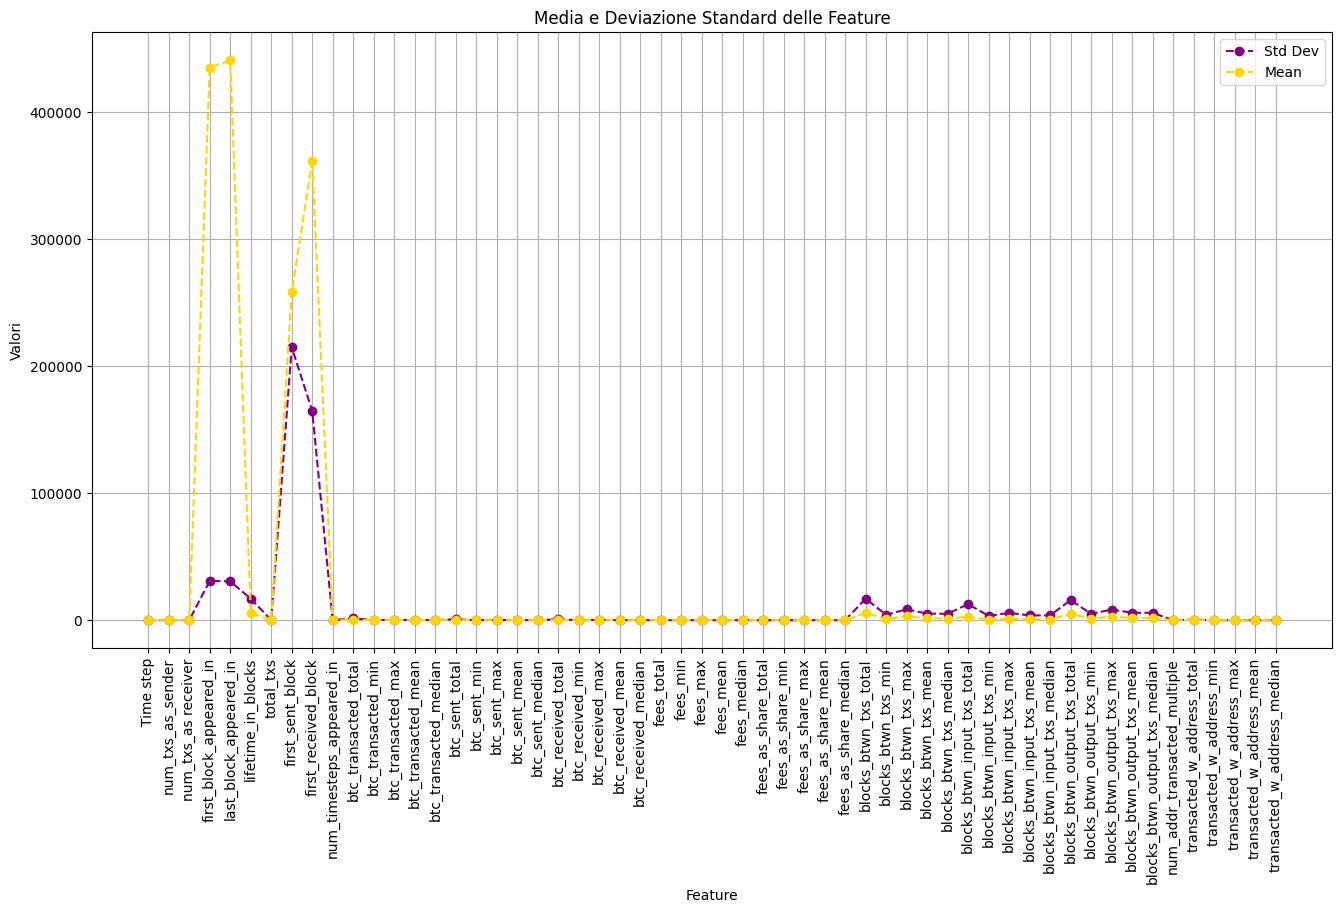

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
wallets_without_class = wallets_features_classes_combined.drop(columns=['class'])

# Calcolare la media e la deviazione standard per tutte le colonne
statistics = wallets_without_class.describe()

# Estrarre media e deviazione standard
means = statistics.loc['mean']
std_devs = statistics.loc['std']

# Definire le caratteristiche
features = means.index.tolist()

# Impostare il grafico
plt.figure(figsize=(16, 8))
plt.plot(features, std_devs, label="Std Dev", color="purple", marker="o", linestyle="dashed")
plt.plot(features, means, label="Mean", color="gold", marker="o", linestyle="dashed")
plt.xticks(rotation=90)
plt.xlabel("Feature")
plt.ylabel("Valori")
plt.title("Media e Deviazione Standard delle Feature")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Statistiche generali su tutte le colonne numeriche
print(wallets_without_class.describe())



          Time step  num_txs_as_sender  num_txs_as receiver  \
count  1.268260e+06       1.268260e+06         1.268260e+06   
mean   2.402671e+01       1.270038e+01         6.566587e+00   
std    1.504961e+01       8.867257e+01         4.582542e+01   
min    1.000000e+00       0.000000e+00         0.000000e+00   
25%    1.000000e+01       0.000000e+00         1.000000e+00   
50%    2.300000e+01       1.000000e+00         1.000000e+00   
75%    3.800000e+01       1.000000e+00         1.000000e+00   
max    4.900000e+01       1.453000e+03         5.480000e+02   

       first_block_appeared_in  last_block_appeared_in  lifetime_in_blocks  \
count             1.268260e+06            1.268260e+06        1.268260e+06   
mean              4.349925e+05            4.407487e+05        5.756226e+03   
std               3.094160e+04            3.056447e+04        1.690569e+04   
min               3.912000e+05            3.912000e+05        0.000000e+00   
25%               4.053210e+05            

In [ ]:
# Mostra il nome delle colonne e il loro tipo di dato
feature_types = wallets_features_classes_combined.dtypes

print(feature_types)

print("Numero features:", len(wallets_features_classes_combined.columns))


address                           object
Time step                          int64
class                              int64
num_txs_as_sender                float64
num_txs_as receiver              float64
first_block_appeared_in          float64
last_block_appeared_in           float64
lifetime_in_blocks               float64
total_txs                        float64
first_sent_block                 float64
first_received_block             float64
num_timesteps_appeared_in        float64
btc_transacted_total             float64
btc_transacted_min               float64
btc_transacted_max               float64
btc_transacted_mean              float64
btc_transacted_median            float64
btc_sent_total                   float64
btc_sent_min                     float64
btc_sent_max                     float64
btc_sent_mean                    float64
btc_sent_median                  float64
btc_received_total               float64
btc_received_min                 float64
btc_received_max

In [ ]:
wallets_without_class = wallets_features_classes_combined.drop(columns=['class'])
statistc = pd.DataFrame(wallets_without_class.describe())
statistc = statistc.iloc[:,:].T
display(statistc)

,count,mean,std,min,25%,50%,75%,max
Time step,1268260.0,24.026708,15.049614,1.0,1.000000e+01,23.000000,38.000000,49.000000
num_txs_as_sender,1268260.0,12.700380,88.672574,0.0,0.000000e+00,1.000000,1.000000,1453.000000
num_txs_as receiver,1268260.0,6.566587,45.825422,0.0,1.000000e+00,1.000000,1.000000,548.000000
first_block_appeared_in,1268260.0,434992.480395,30941.598656,391200.0,4.053210e+05,431529.000000,463777.000000,487975.000000
last_block_appeared_in,1268260.0,440748.706196,30564.465158,391200.0,4.113630e+05,439589.000000,469828.000000,487975.000000
lifetime_in_blocks,1268260.0,5756.225801,16905.687625,0.0,0.000000e+00,0.000000,5.000000,96775.000000
total_txs,1268260.0,19.266962,116.423712,1.0,1.000000e+00,2.000000,2.000000,1471.000000
first_sent_block,1268260.0,258239.879048,214962.835049,0.0,0.000000e+00,397257.000000,441606.000000,487975.000000
first_received_block,1268260.0,361634.205947,164693.333072,0.0,3.952320e+05,419429.000000,459747.000000,487975.000000
num_timesteps_appeared_in,1268260.0,1.871110,3.898093,1.0,1.000000e+00,1.000000,1.000000,47.000000


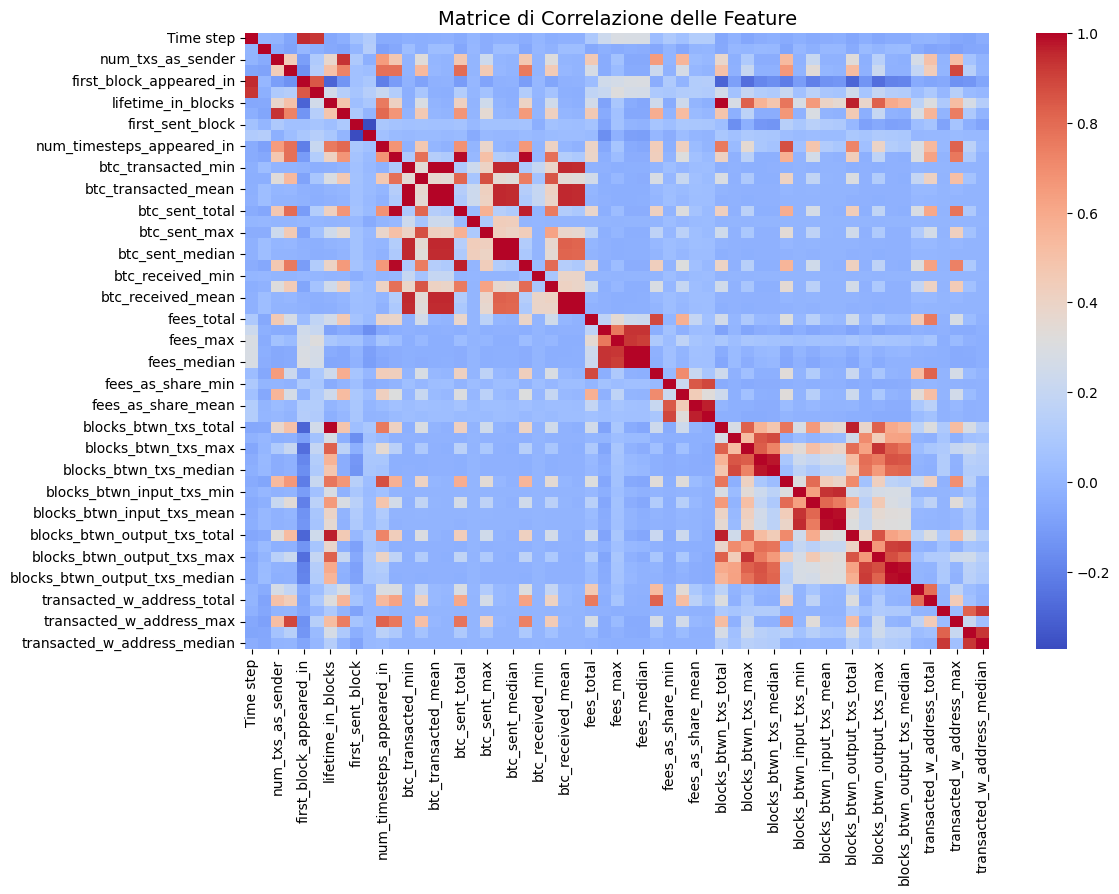

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Escludiamo le colonne non numeriche (address e class)
numeric_df = wallets_features_classes_combined.select_dtypes(include=[np.number])

# Calcolare la matrice di correlazione solo per le colonne numeriche
correlation_matrix = numeric_df.corr()

# Visualizzare la matrice di correlazione
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Matrice di Correlazione delle Feature", fontsize=14)
plt.show()


In [ ]:
def plot_feature_statistics(features, statistics, title=''):
    # Estrarre statistiche
    max_values = statistics.loc['max']
    min_values = statistics.loc['min']
    q_25 = statistics.loc['25%']
    q_50 = statistics.loc['50%']
    q_75 = statistics.loc['75%']

    means = statistics.loc['mean']
    std_devs = statistics.loc['std']

    # Grafico per Massimi, Minimi
    plt.figure(figsize=(16, 8))
    plt.plot(features, max_values, label="Max", color="#440154", marker="o", linestyle="dashed")
    plt.plot(features, min_values, label="Min", color="#fde725", marker="o", linestyle="dashed")
    plt.xticks(rotation=90)  # Ruotiamo i nomi delle feature per leggibilità
    plt.xlabel("Feature")
    plt.ylabel("Valori")
    plt.title(f"{title} - Massimi e Minimi")
    plt.legend()
    plt.grid()
    plt.show()

    # Grafico per Quartili
    plt.figure(figsize=(16, 8))
    plt.plot(features, q_75, label="Q_3", color="#414487", marker="o", linestyle="dashed")
    plt.plot(features, q_50, label="Q_2", color="#2A788e", marker="o", linestyle="dashed")
    plt.plot(features, q_25, label="Q_1", color="#22A884", marker="o", linestyle="dashed")
    plt.xticks(rotation=90)  # Ruotiamo i nomi delle feature per leggibilità
    plt.xlabel("Feature")
    plt.ylabel("Valori")
    plt.title(f"{title} - Andamento Quartili")
    plt.legend()
    plt.grid()
    plt.show()

    # Grafico per Media e Deviazione Standard

    plt.figure(figsize=(16, 8))
    plt.plot(features, std_devs, label="Std Dev", color="purple", marker="o", linestyle="dashed")
    plt.plot(features, means, label="Mean", color="gold", marker="o", linestyle="dashed")
    plt.xticks(rotation=90)
    plt.xlabel("Feature")
    plt.ylabel("Valori")
    plt.title(f"{title} - Media e Deviazione Standard")
    plt.legend()
    plt.grid()
    plt.show()

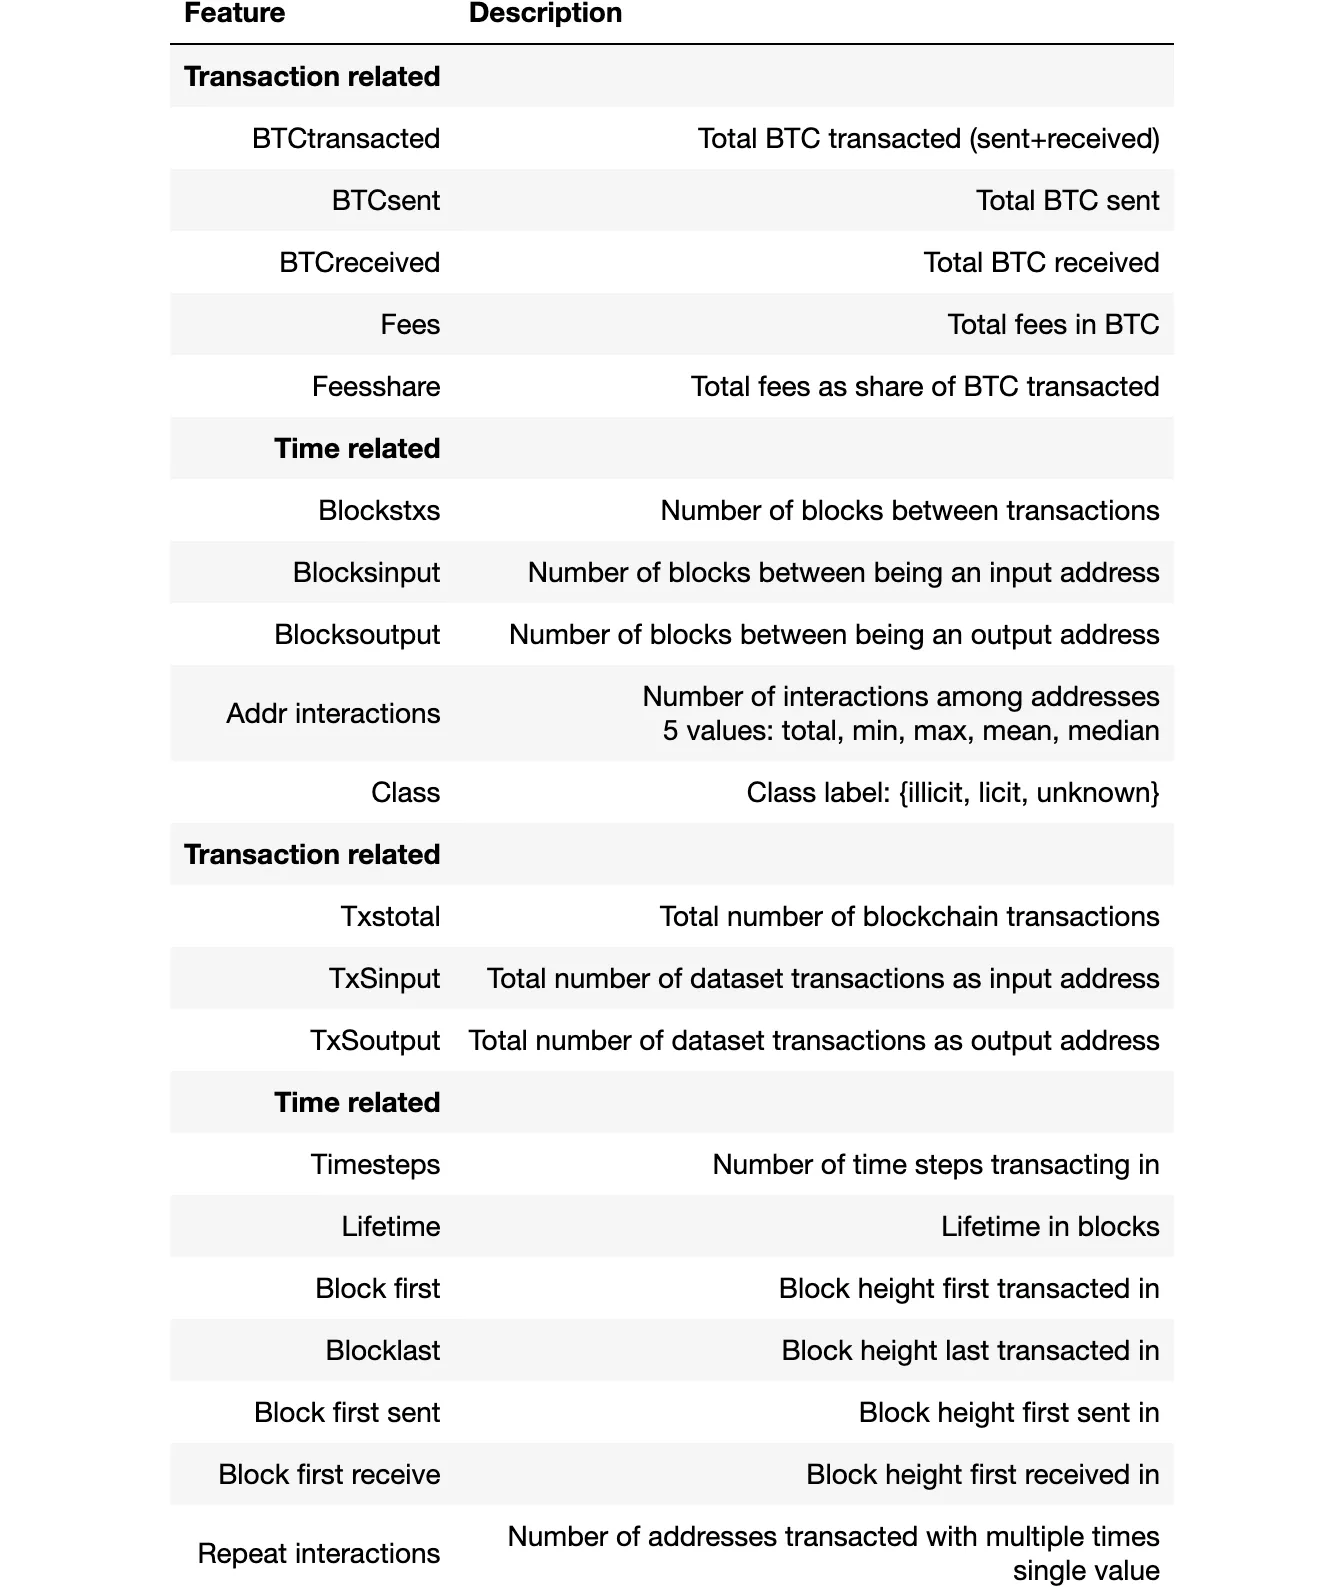 Guardando questa tabella ho preso l'elenco stampato qualche cella più su e ho risuddiviso le features sulla base di quella della documentazione (https://medium.com/@marcelboersma/elliptic-fbc7e008db2b)

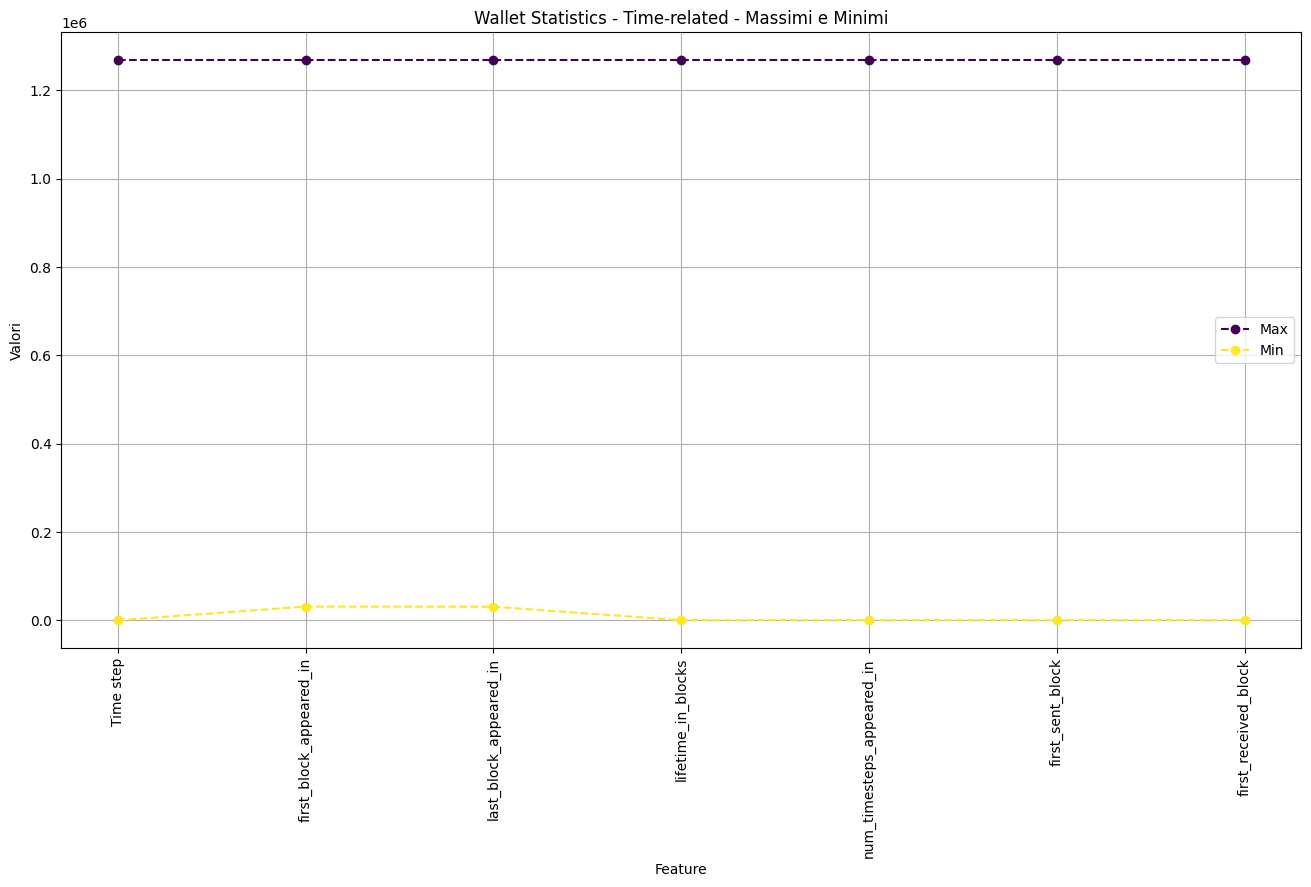

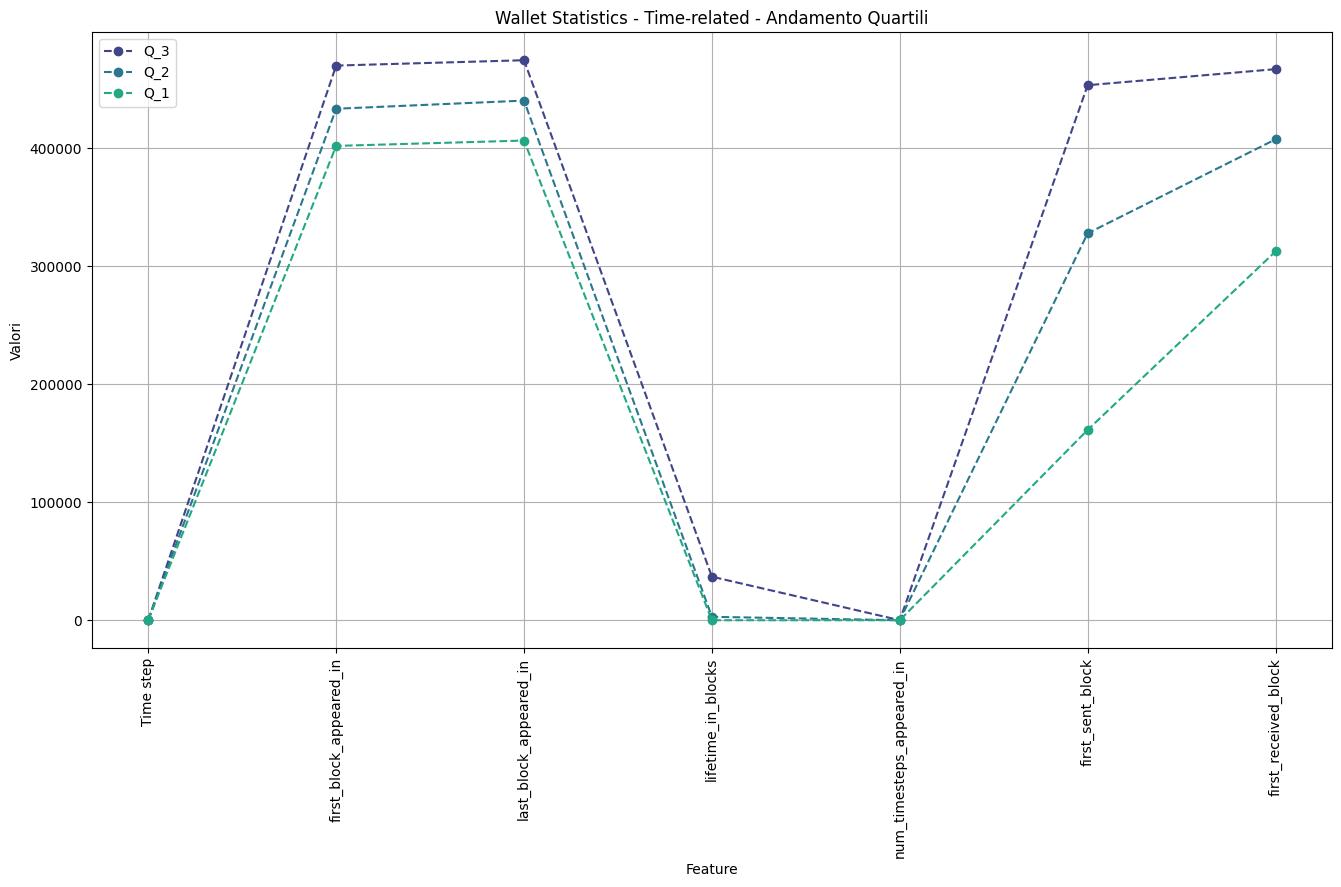

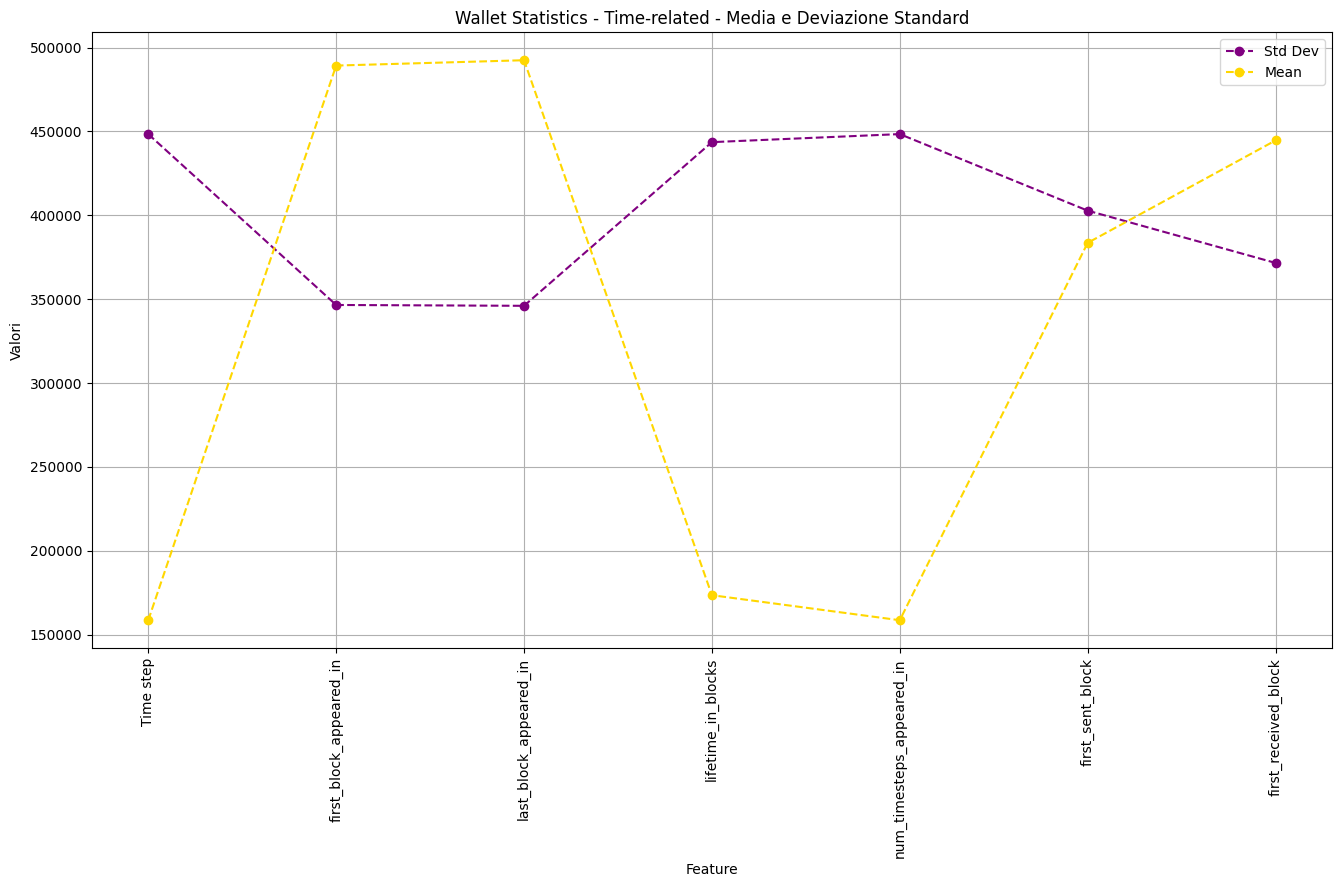

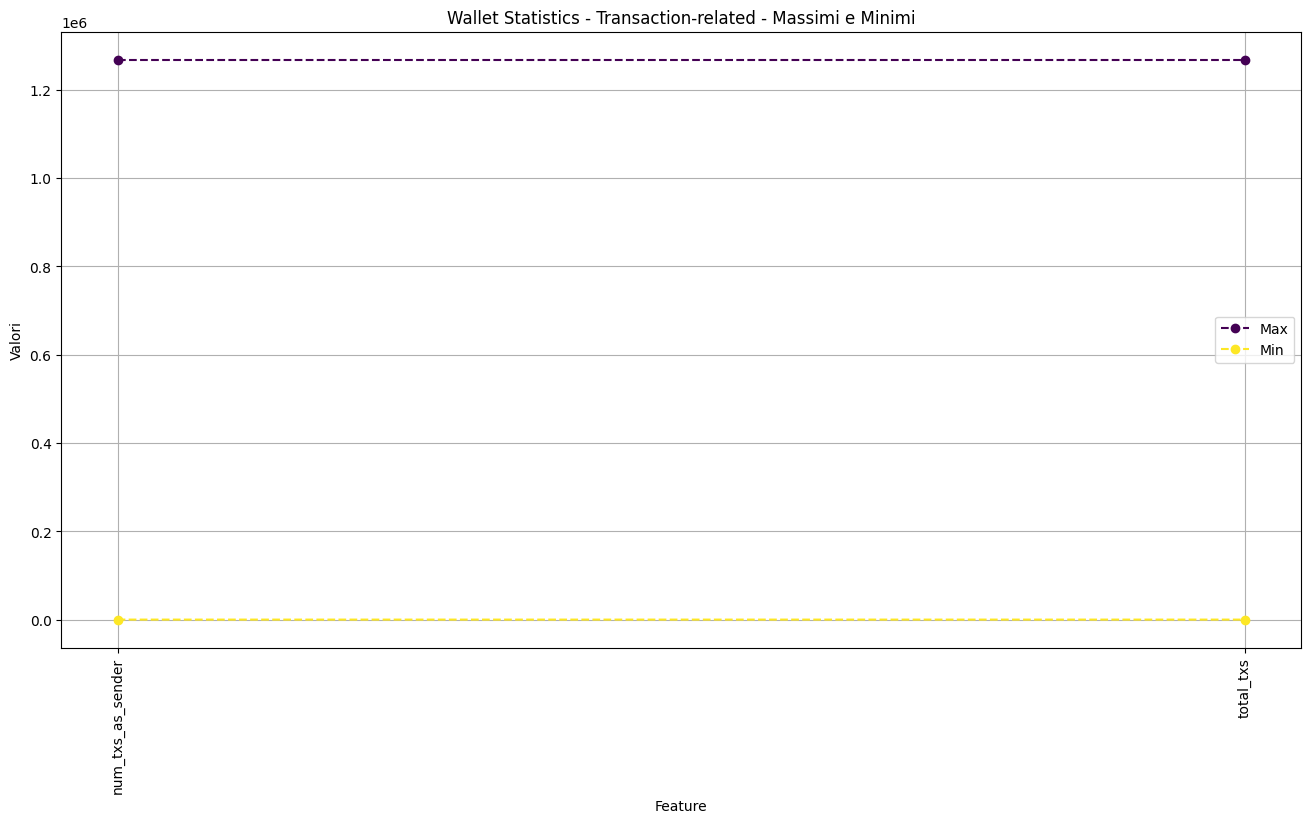

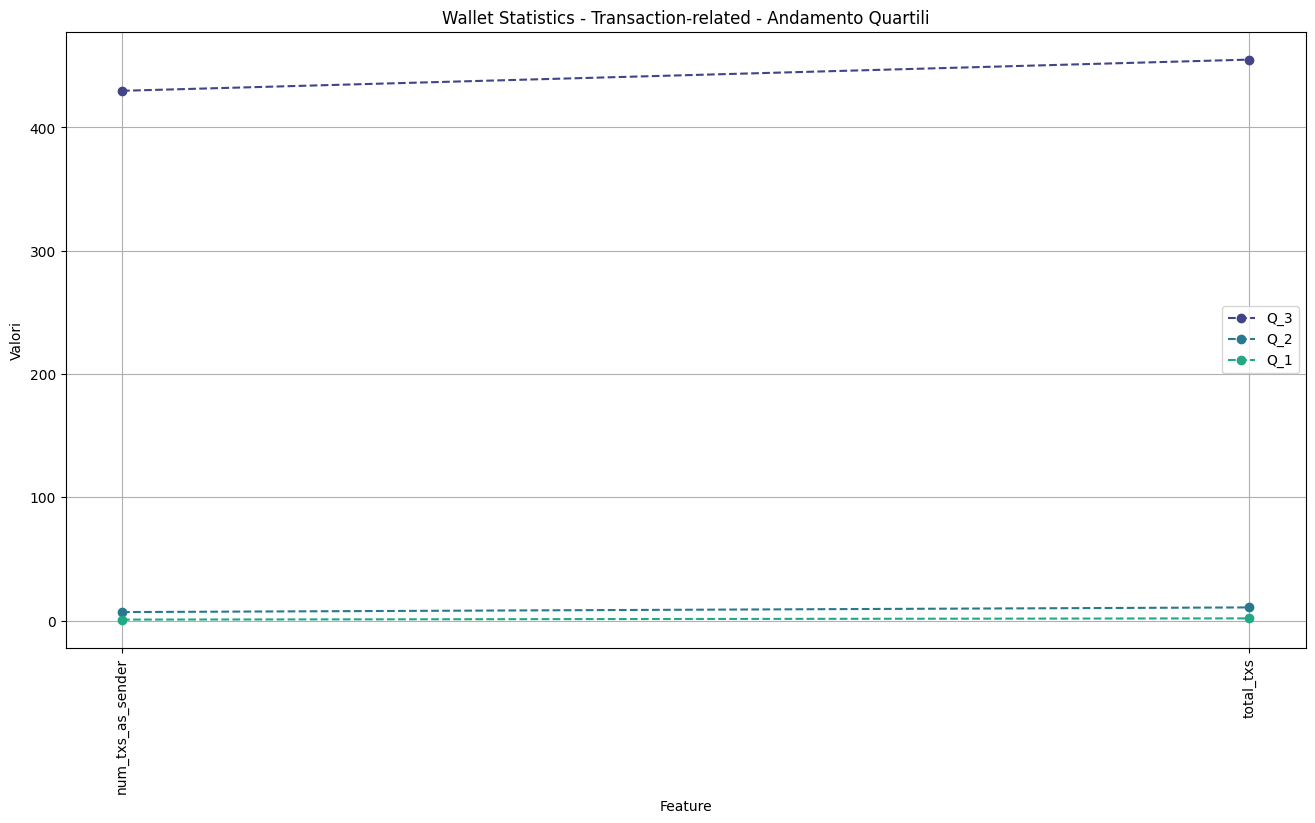

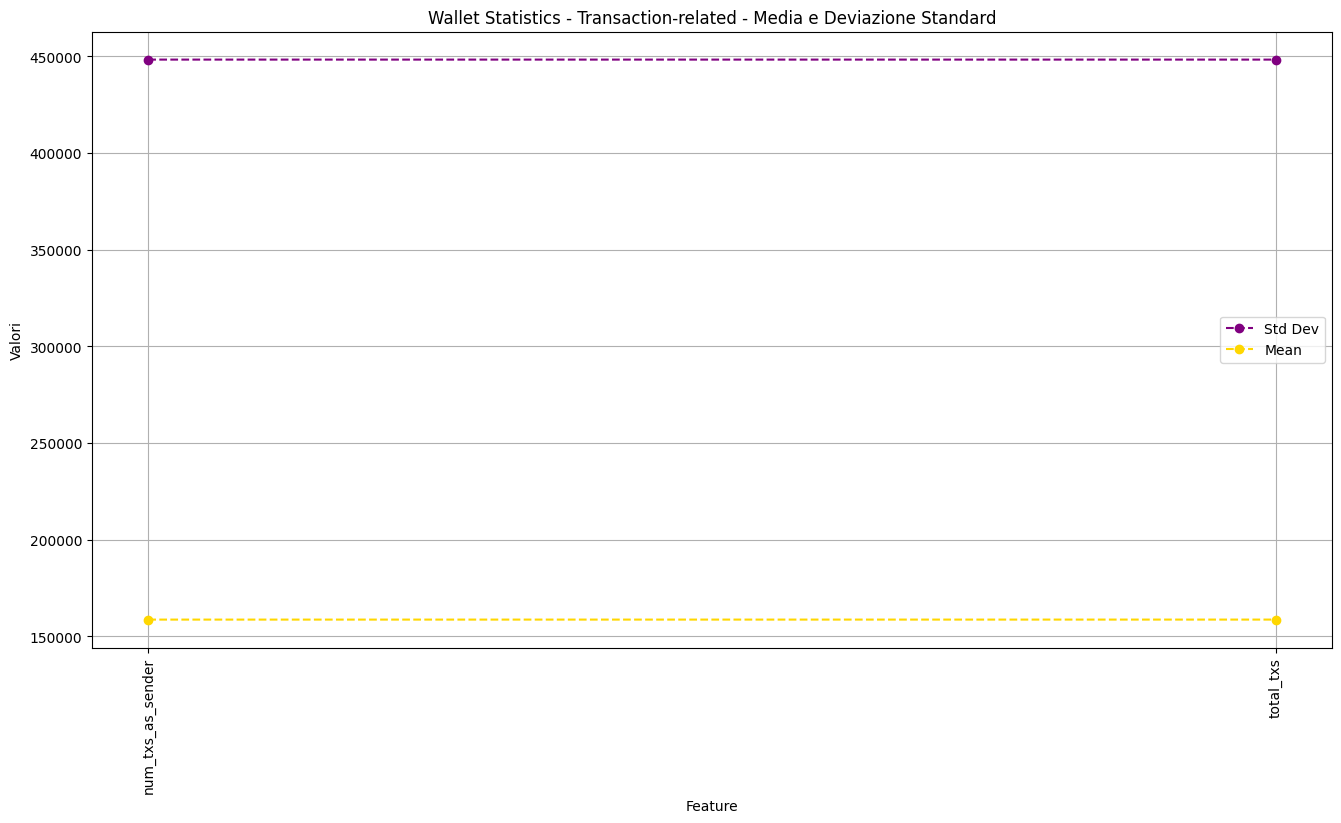

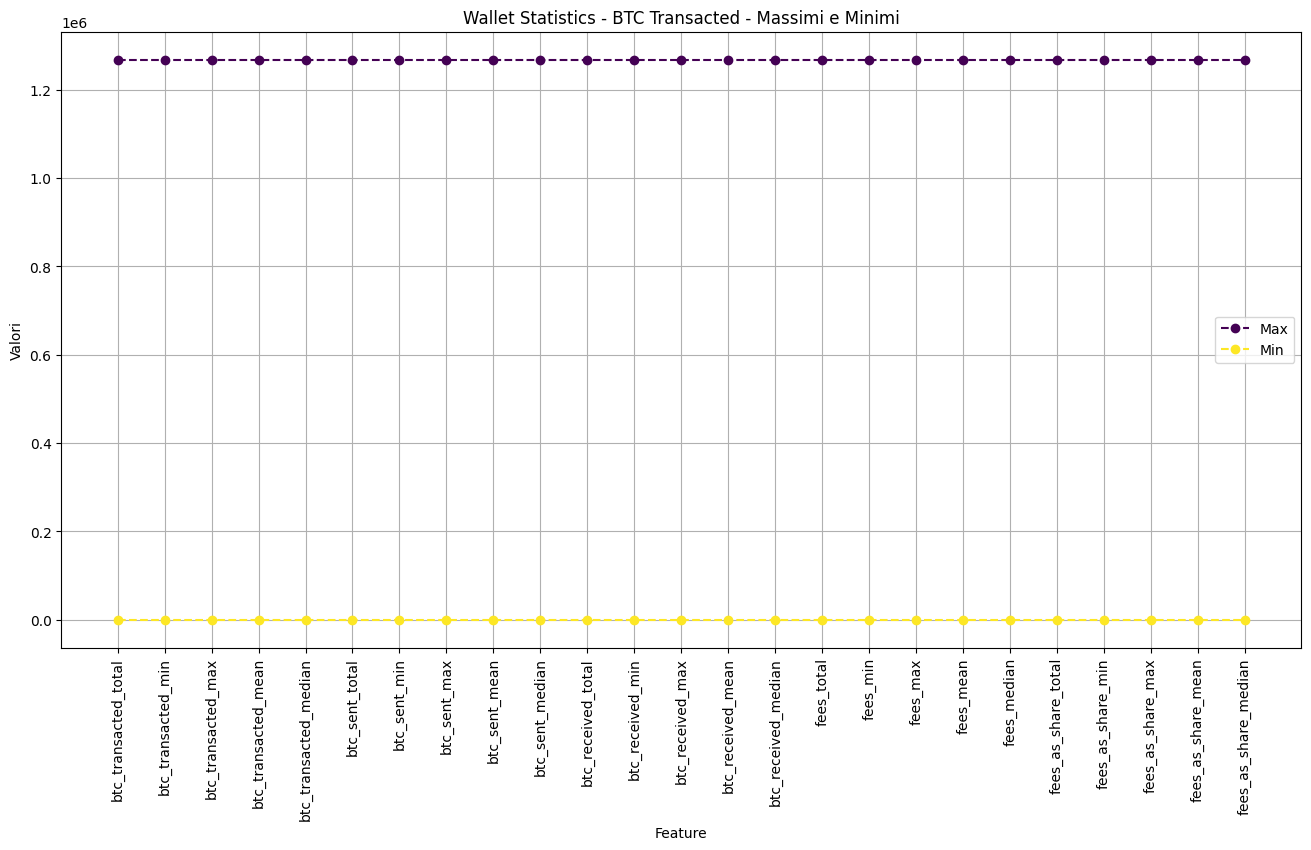

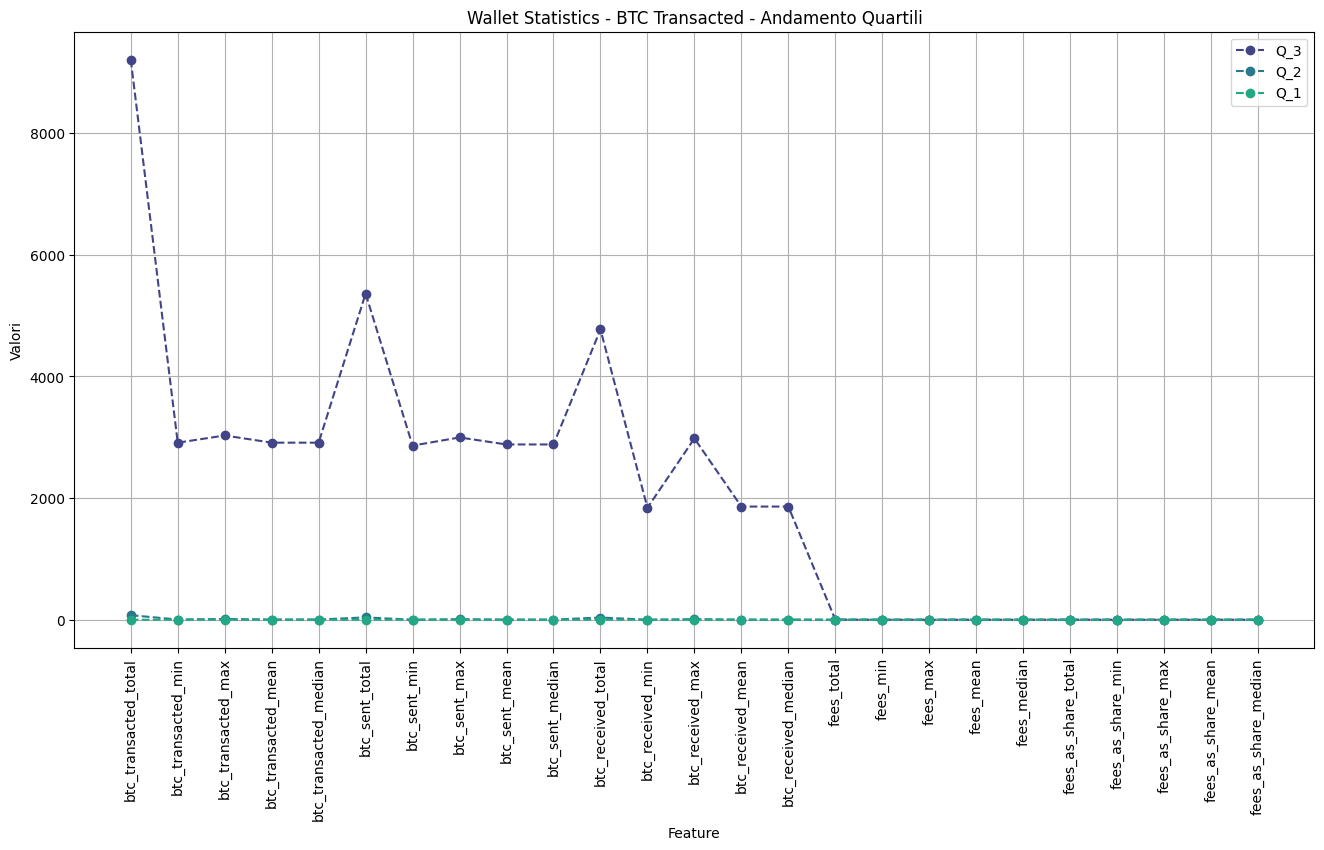

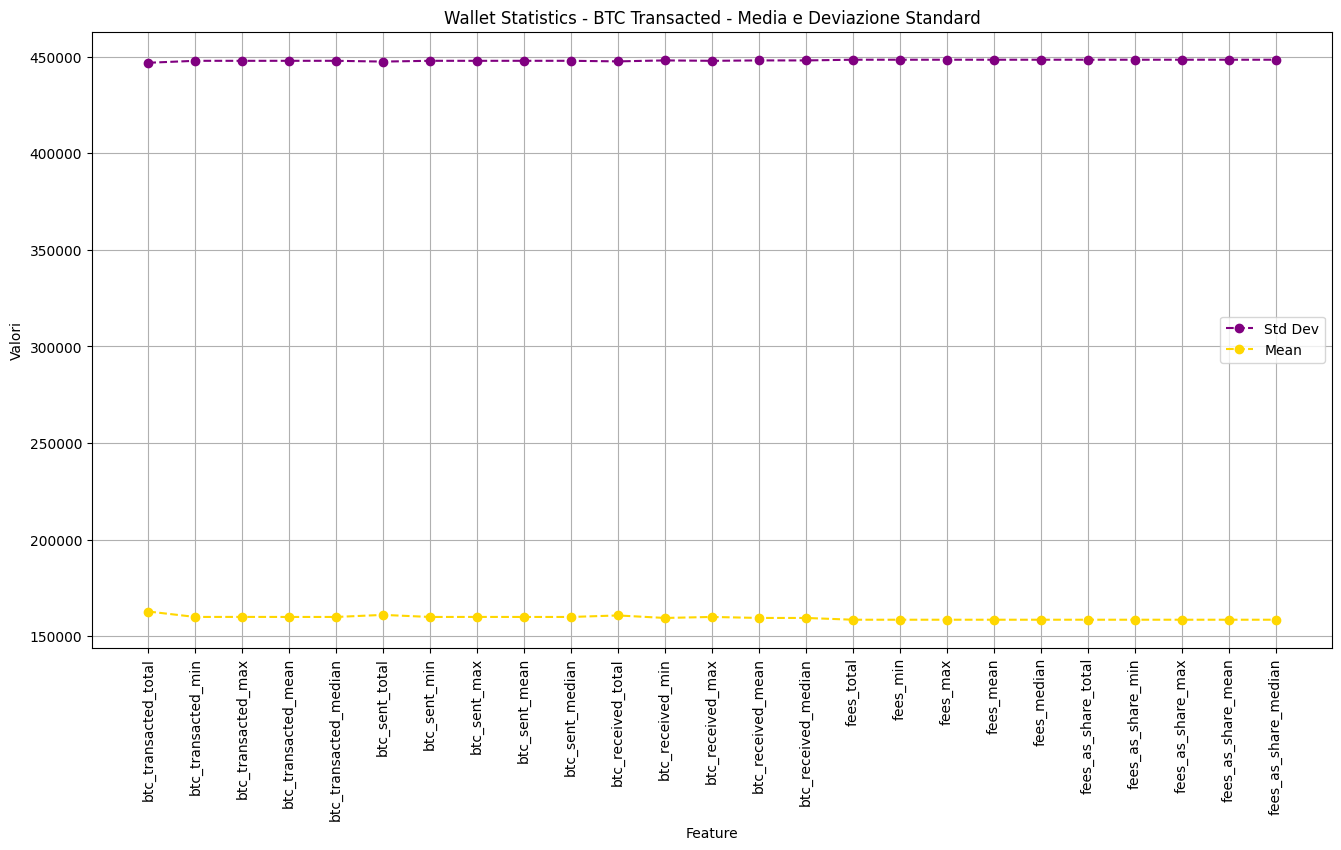

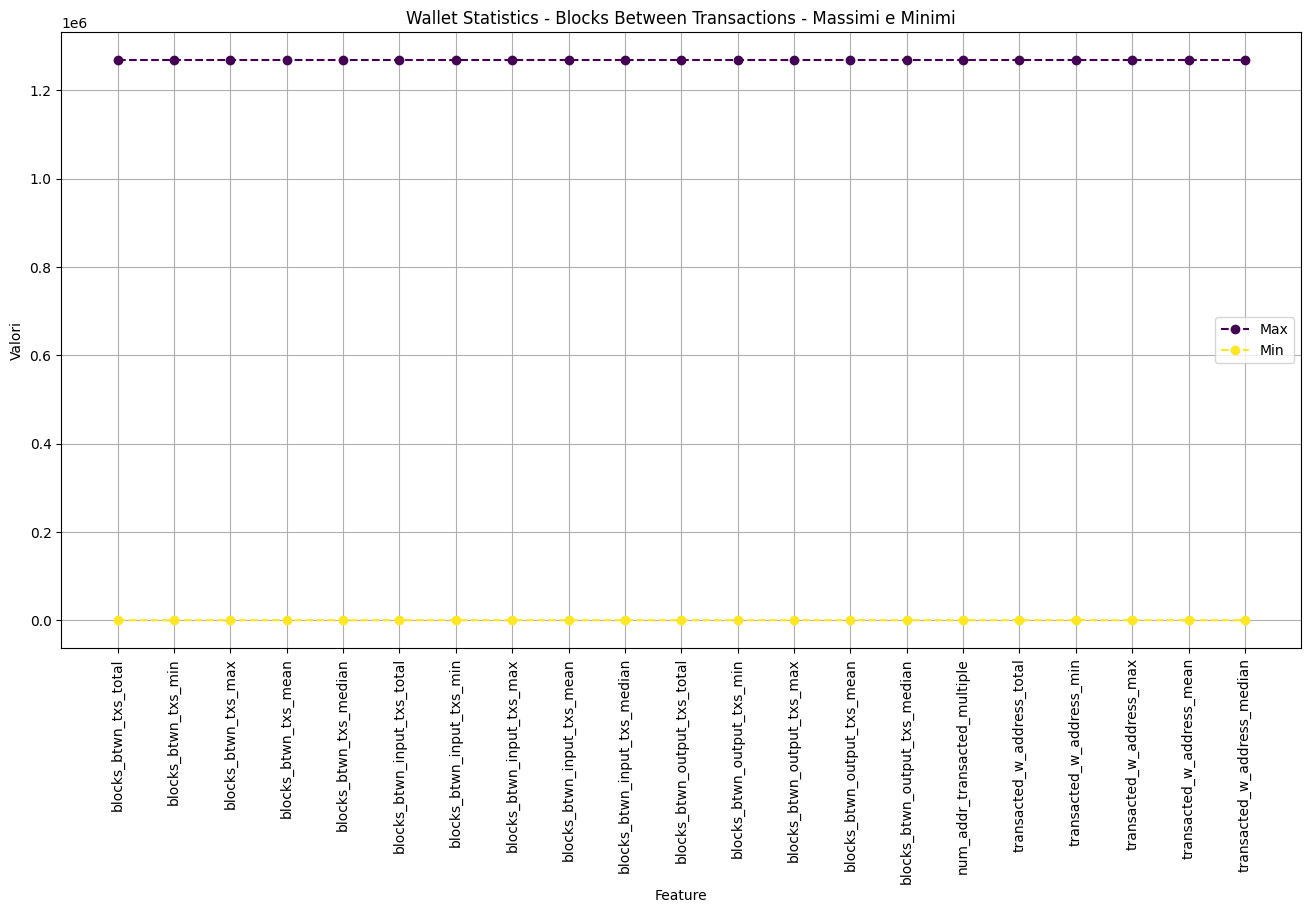

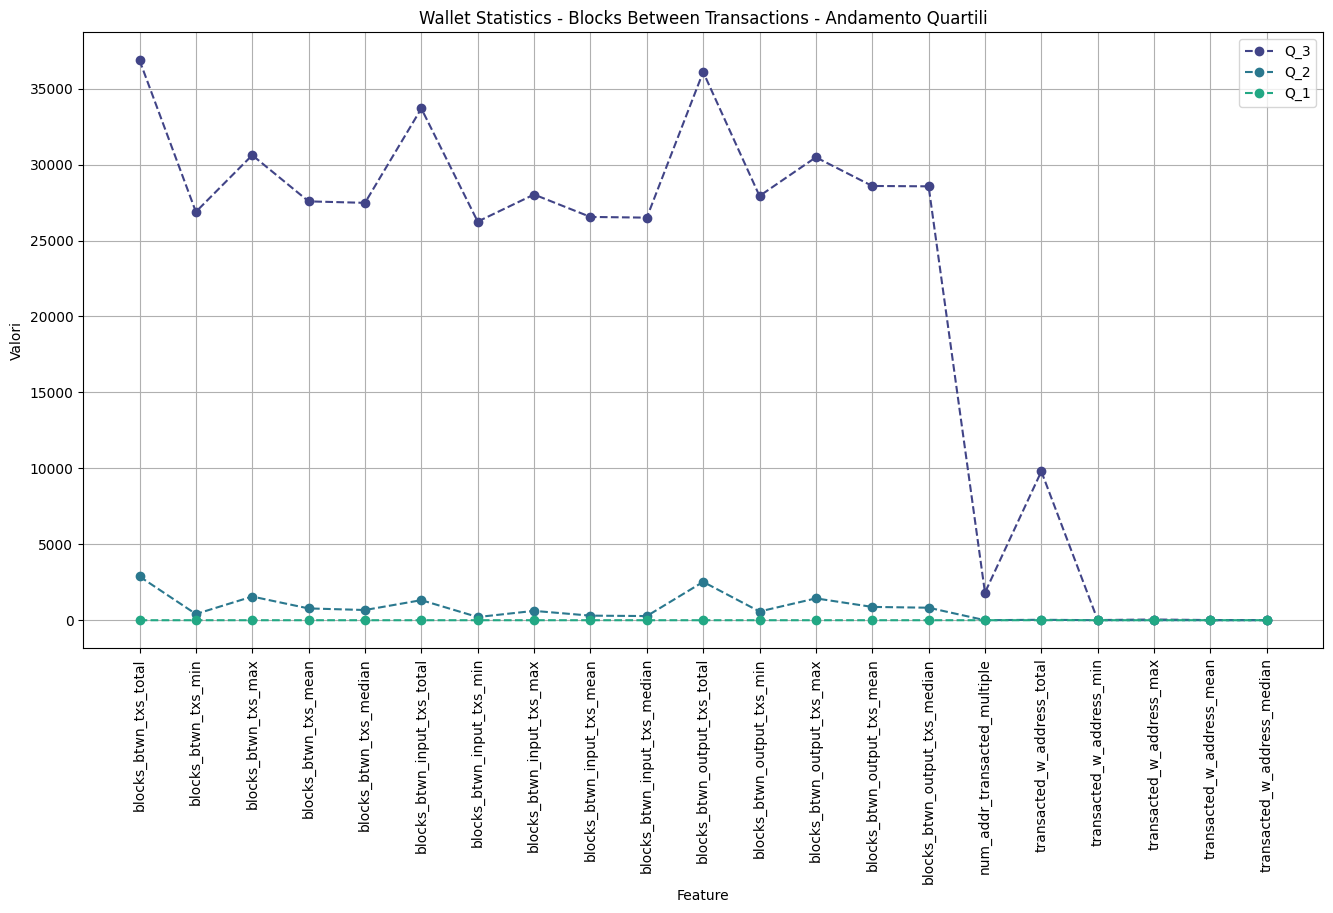

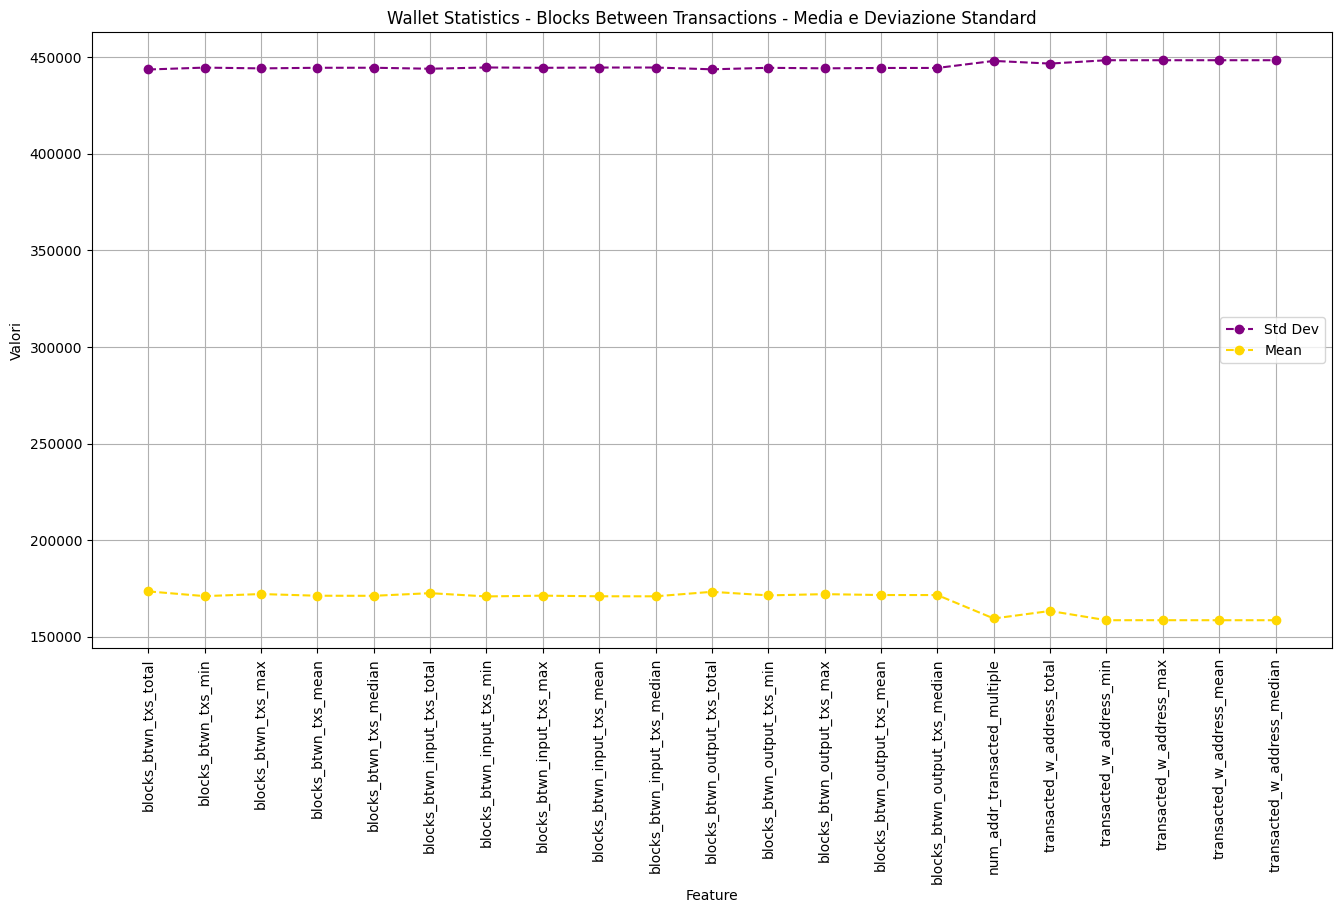

In [ ]:

import pandas as pd

def plot_statistics(data, features, title=''):
    # Definizione dei gruppi di feature
    feature_groups = {
        "Time-related": [
            'Time step', 'first_block_appeared_in', 'last_block_appeared_in',
            'lifetime_in_blocks', 'num_timesteps_appeared_in',
            'first_sent_block', 'first_received_block'
        ],
        "Transaction-related": [
            'num_txs_as_sender', 'num_txs_as_receiver', 'total_txs'
        ],
        "BTC Transacted": [
            'btc_transacted_total', 'btc_transacted_min', 'btc_transacted_max',
            'btc_transacted_mean', 'btc_transacted_median',
            'btc_sent_total', 'btc_sent_min', 'btc_sent_max',
            'btc_sent_mean', 'btc_sent_median',
            'btc_received_total', 'btc_received_min', 'btc_received_max',
            'btc_received_mean', 'btc_received_median',
            'fees_total', 'fees_min', 'fees_max', 'fees_mean', 'fees_median',
            'fees_as_share_total', 'fees_as_share_min', 'fees_as_share_max',
            'fees_as_share_mean', 'fees_as_share_median'
        ],
        "Blocks Between Transactions": [
            'blocks_btwn_txs_total', 'blocks_btwn_txs_min', 'blocks_btwn_txs_max',
            'blocks_btwn_txs_mean', 'blocks_btwn_txs_median',
            'blocks_btwn_input_txs_total', 'blocks_btwn_input_txs_min', 'blocks_btwn_input_txs_max',
            'blocks_btwn_input_txs_mean', 'blocks_btwn_input_txs_median',
            'blocks_btwn_output_txs_total', 'blocks_btwn_output_txs_min', 'blocks_btwn_output_txs_max',
            'blocks_btwn_output_txs_mean', 'blocks_btwn_output_txs_median',
            'num_addr_transacted_multiple', 'transacted_w_address_total', 'transacted_w_address_min',
            'transacted_w_address_max', 'transacted_w_address_mean', 'transacted_w_address_median'
        ]
    }

    # Creiamo un dizionario per contenere le statistiche di ogni gruppo
    statistics_by_group = {}

    for group_name, group_features in feature_groups.items():
        # Selezioniamo solo le feature presenti nei dati
        selected_features = [f for f in group_features if f in features]

        if selected_features:
            # Creiamo un dataframe con le feature selezionate
            statistics_by_group[group_name] = data[selected_features].describe()

    # Creazione dei grafici per ogni categoria
    for group_name, stats_df in statistics_by_group.items():
        plot_feature_statistics(stats_df.columns, stats_df, title=f"{title} - {group_name}")

# Chiamata alla funzione
plot_statistics(statistics, features, title="Wallet Statistics")


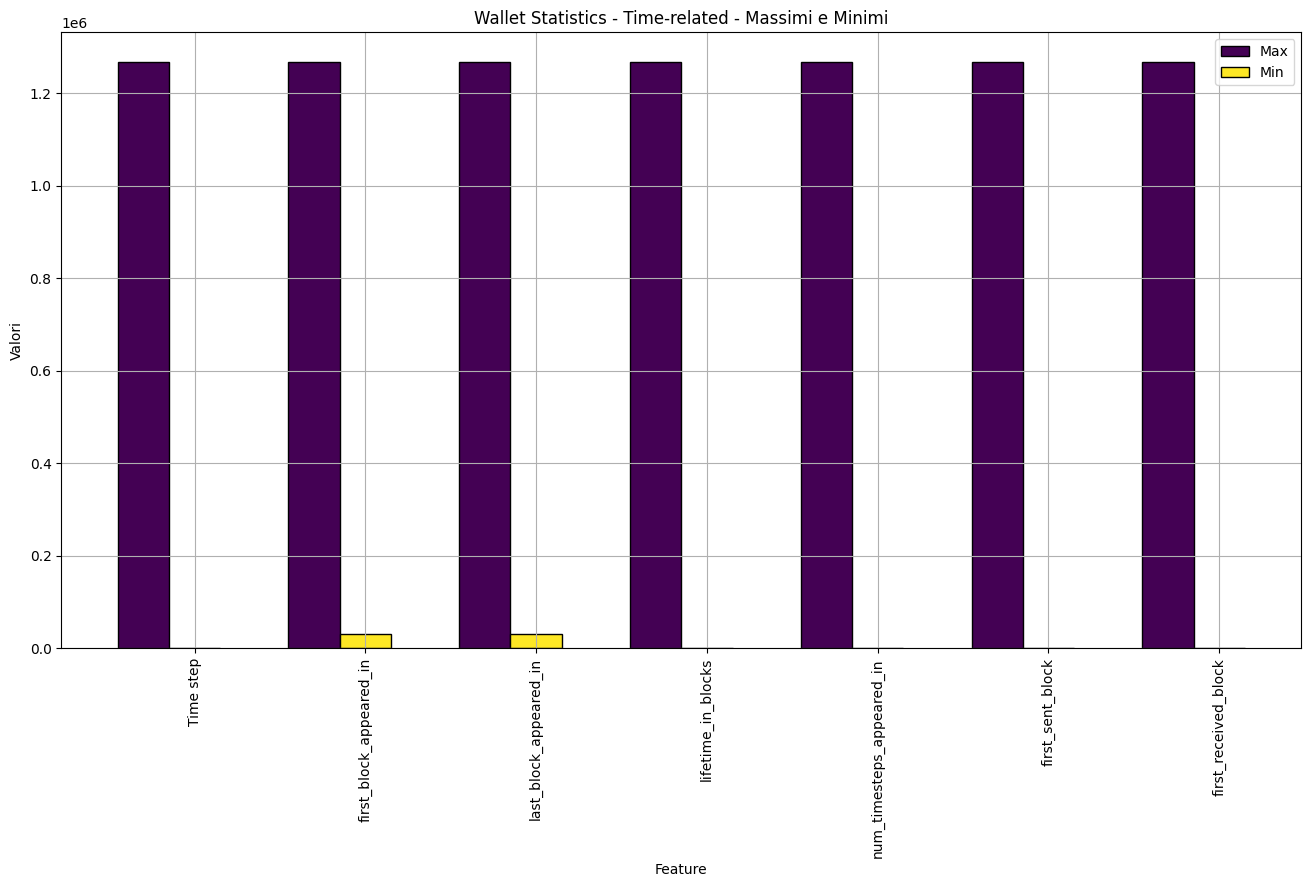

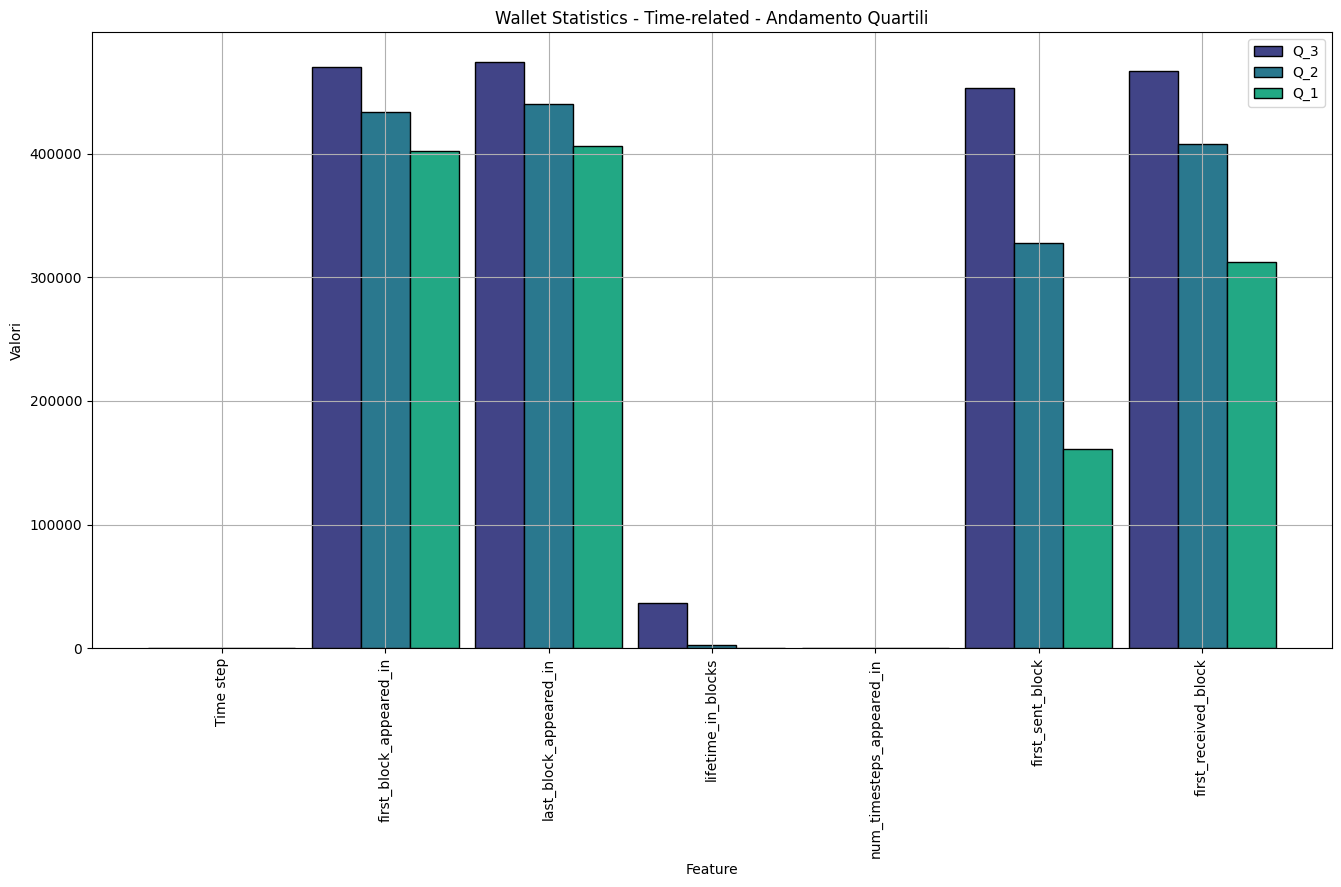

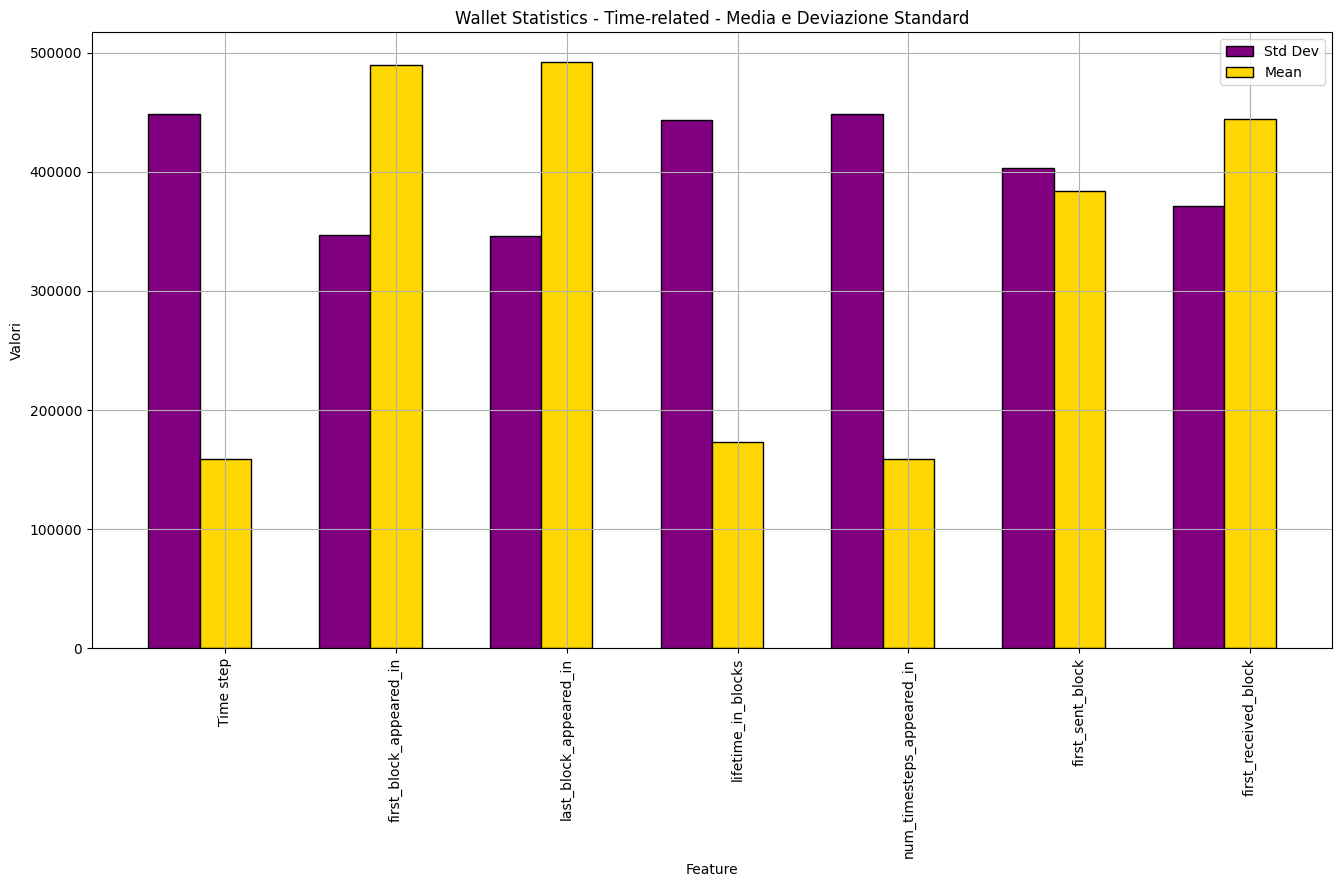

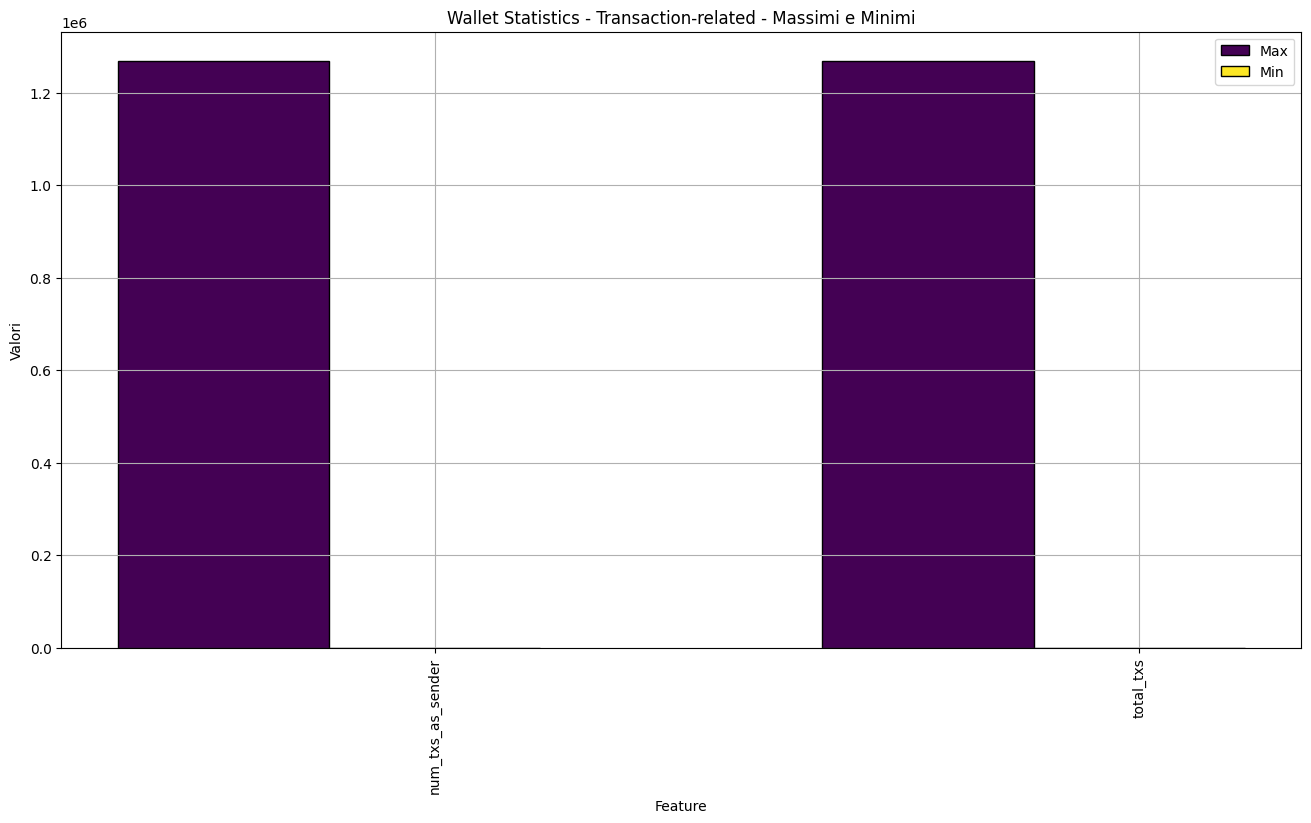

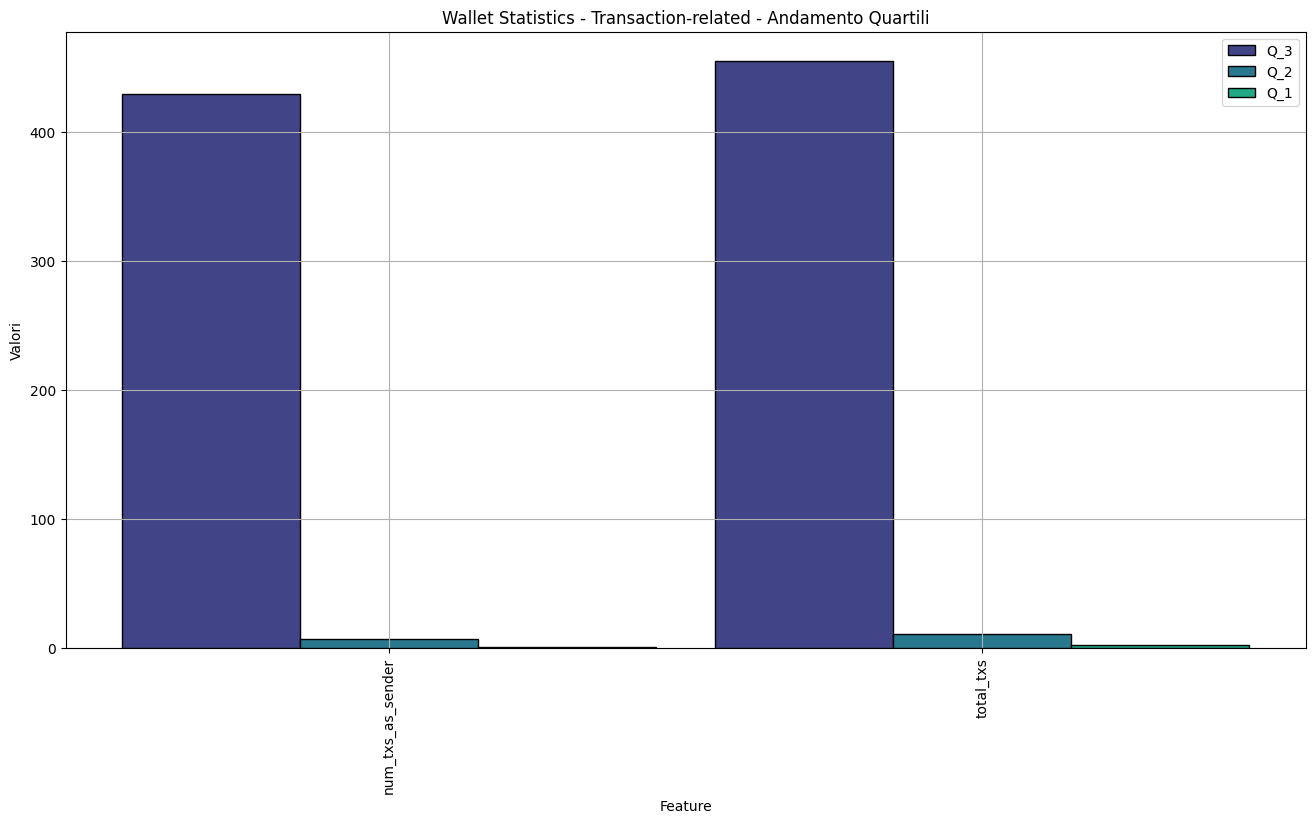

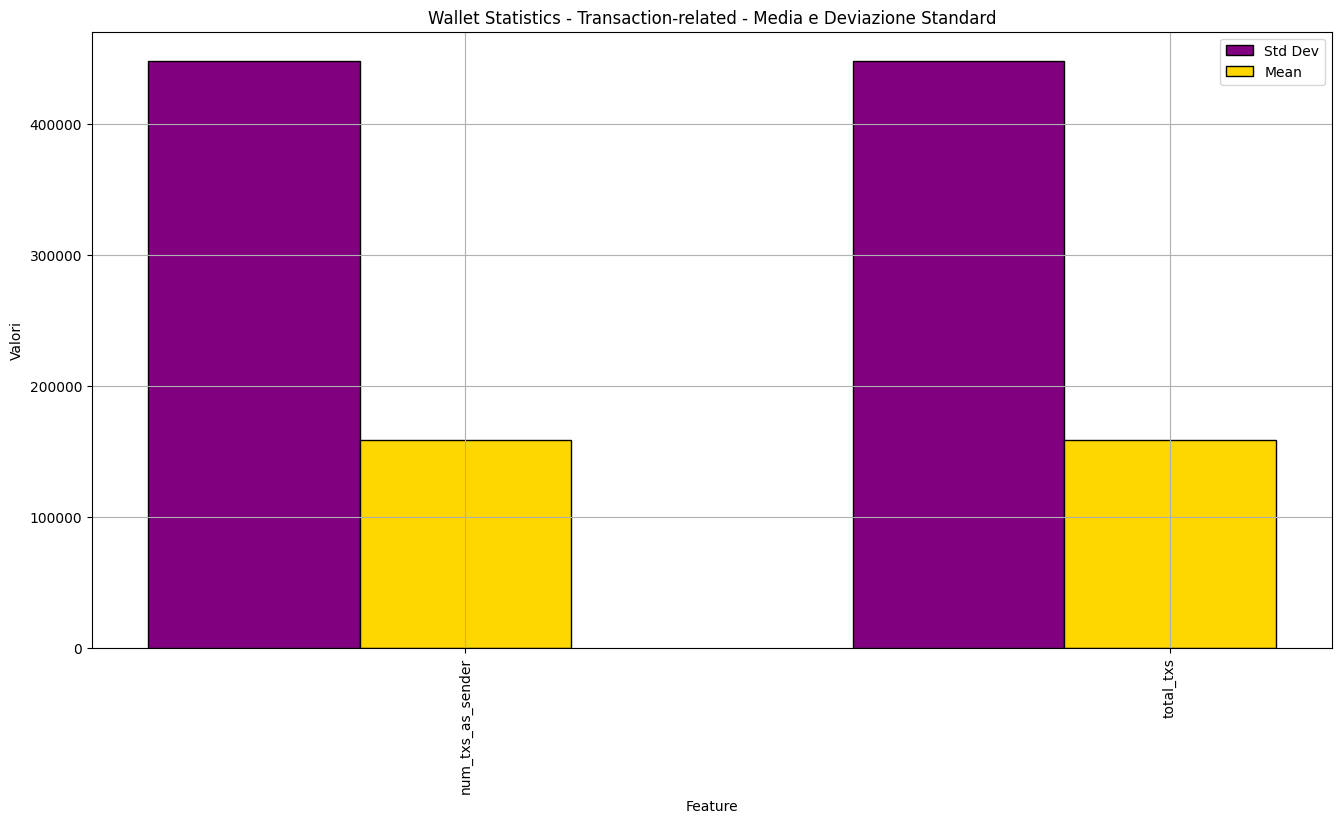

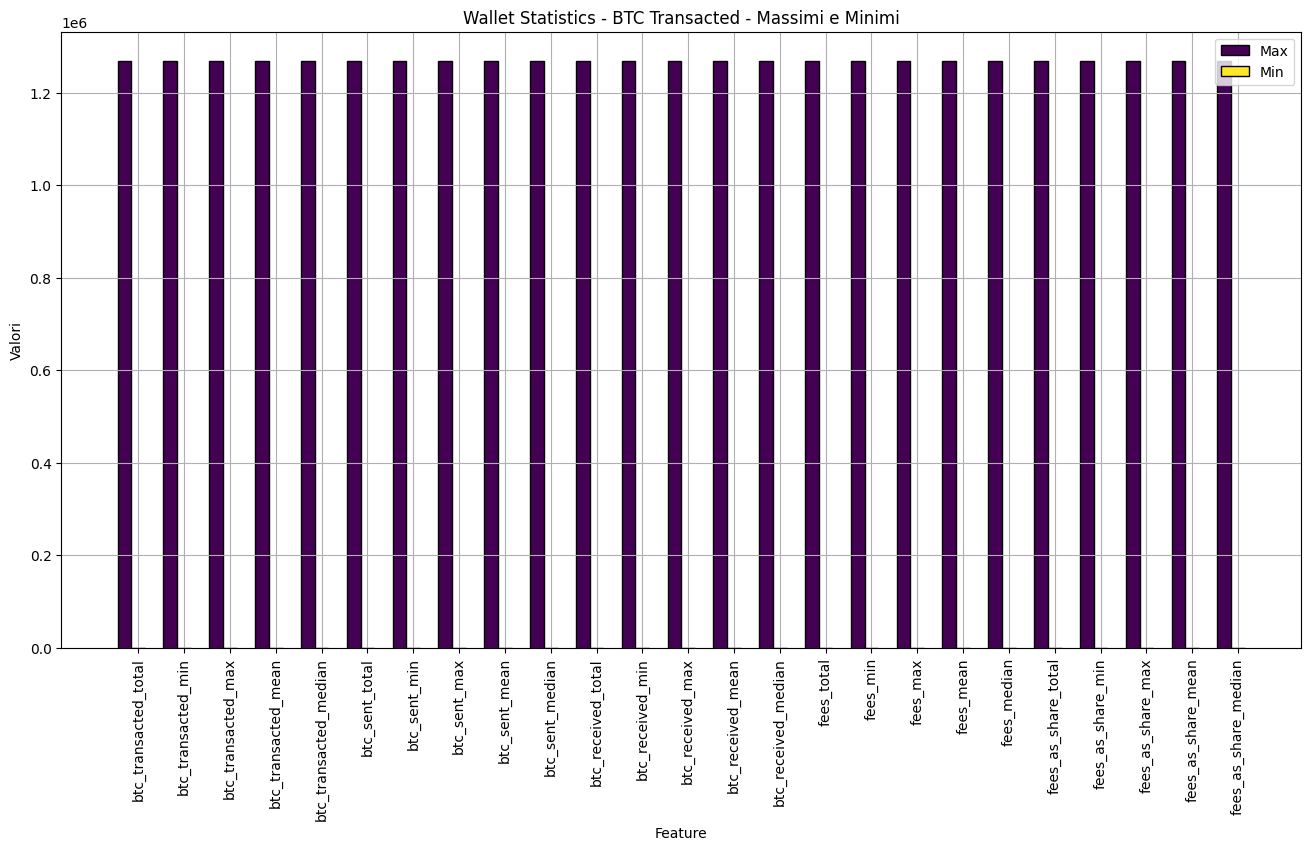

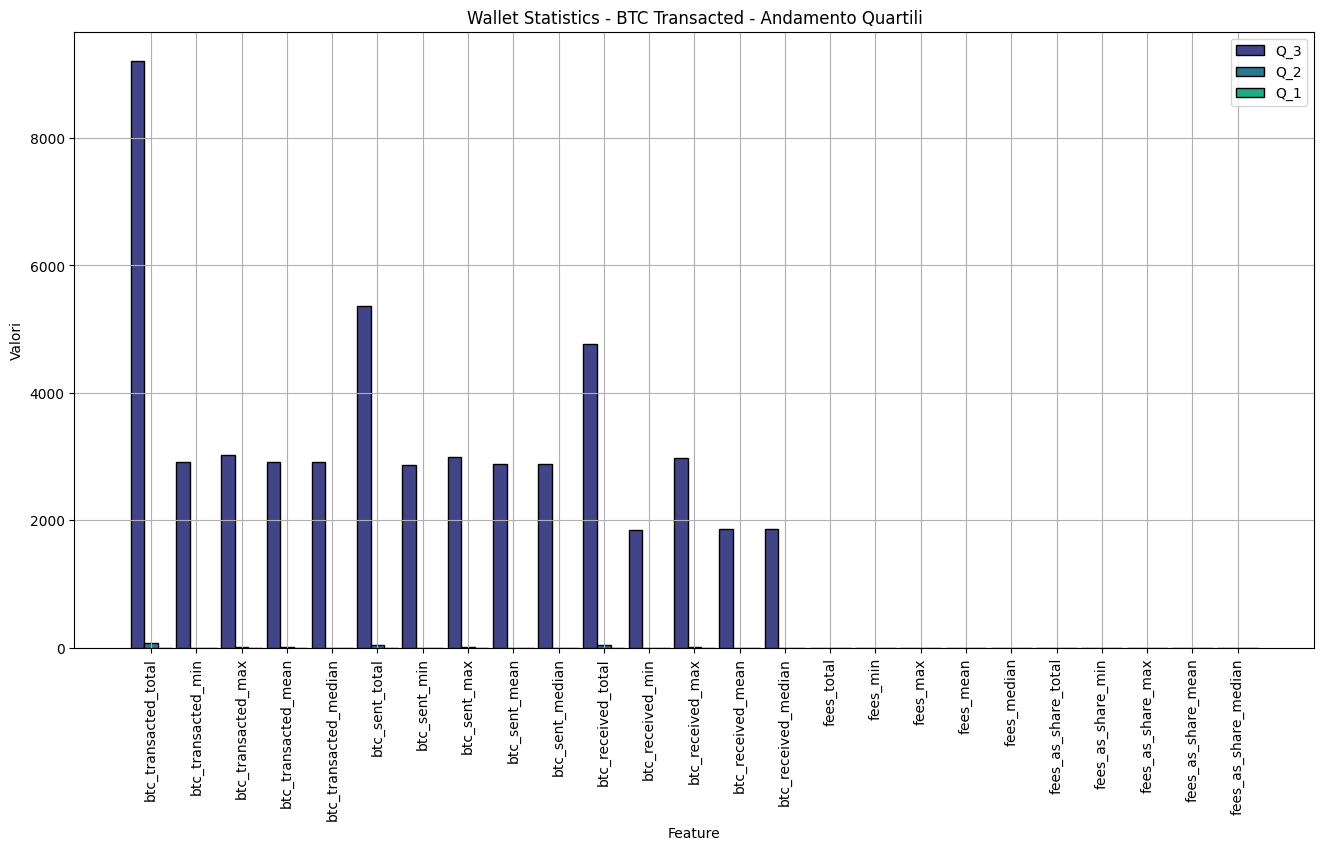

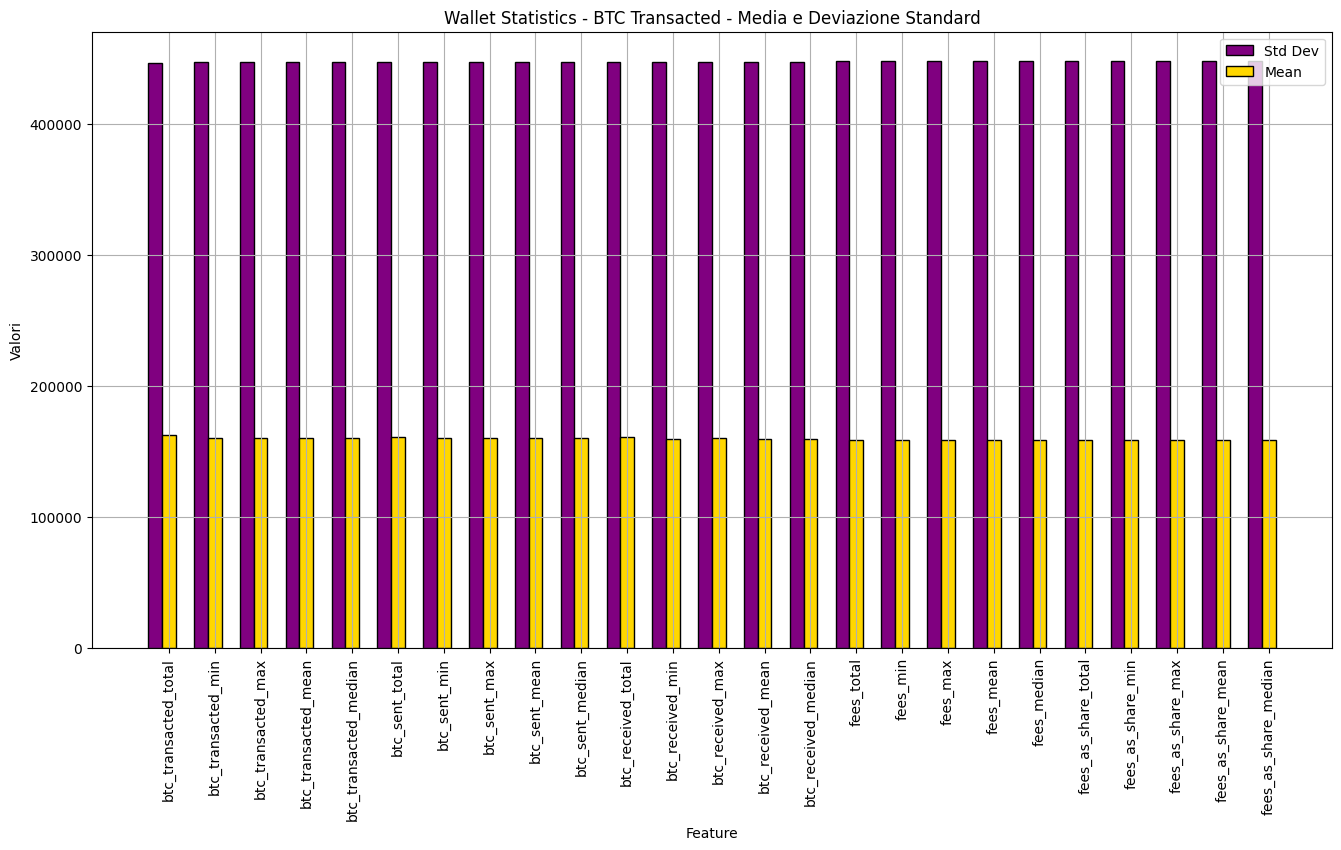

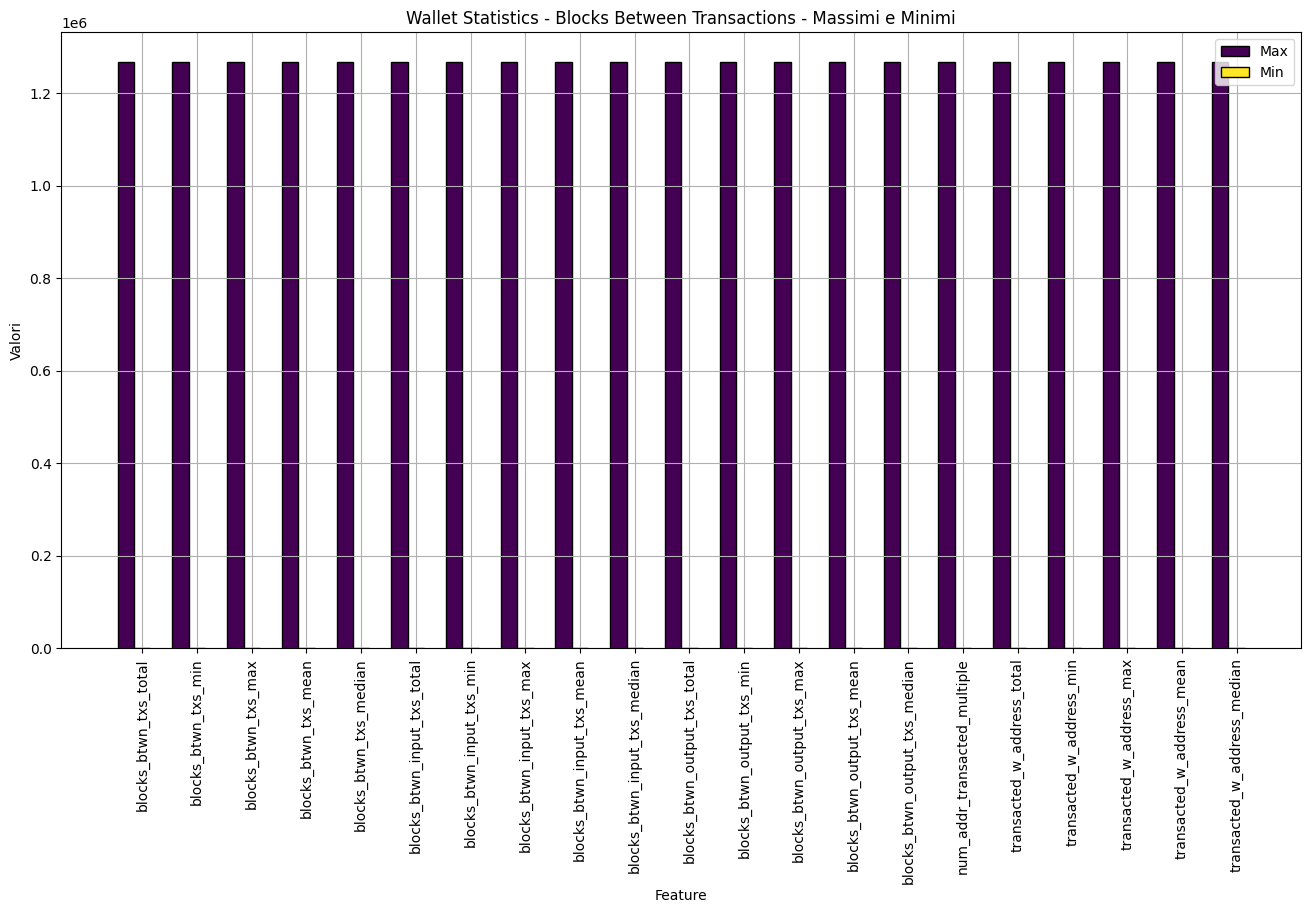

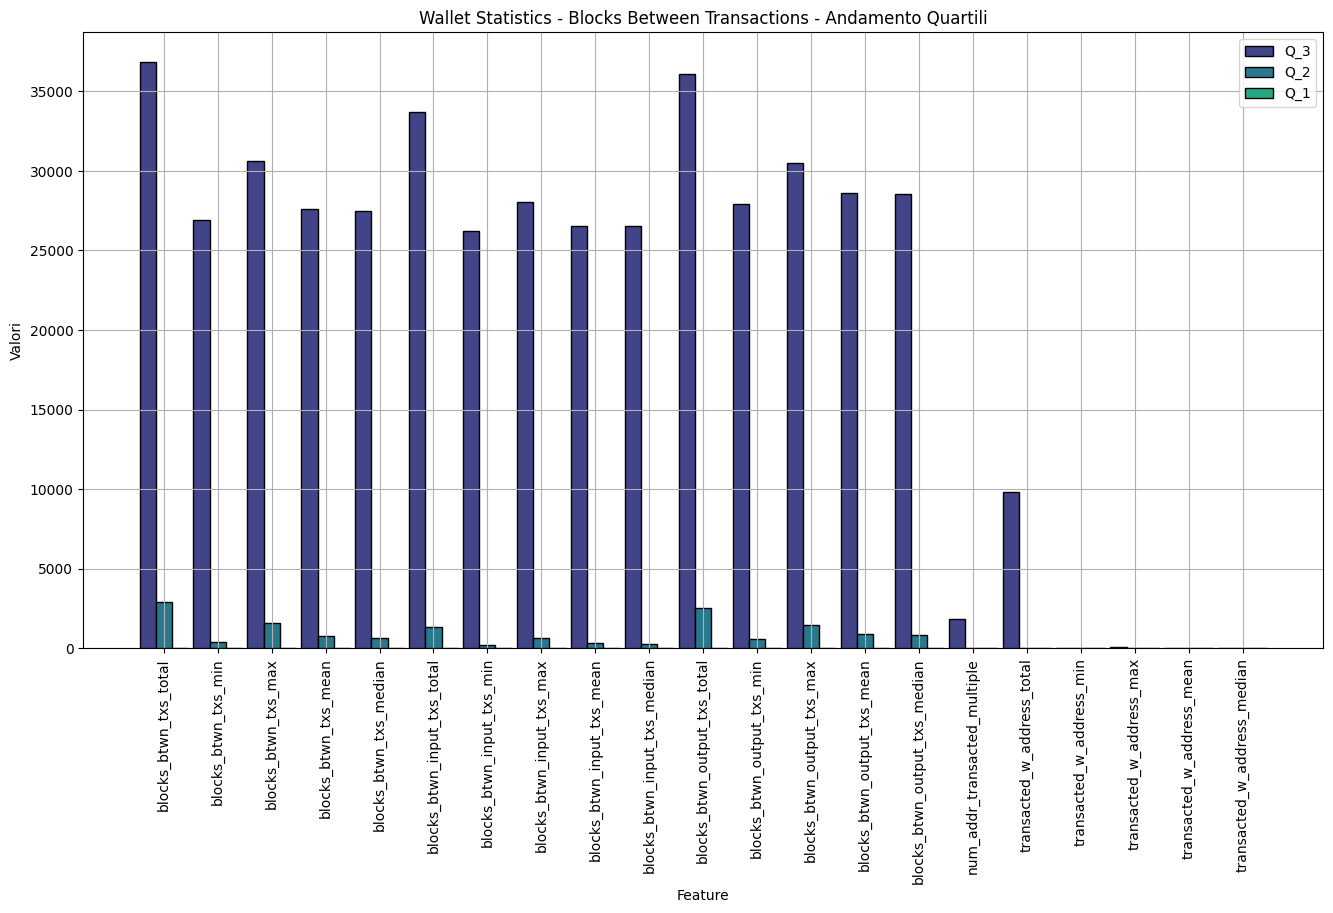

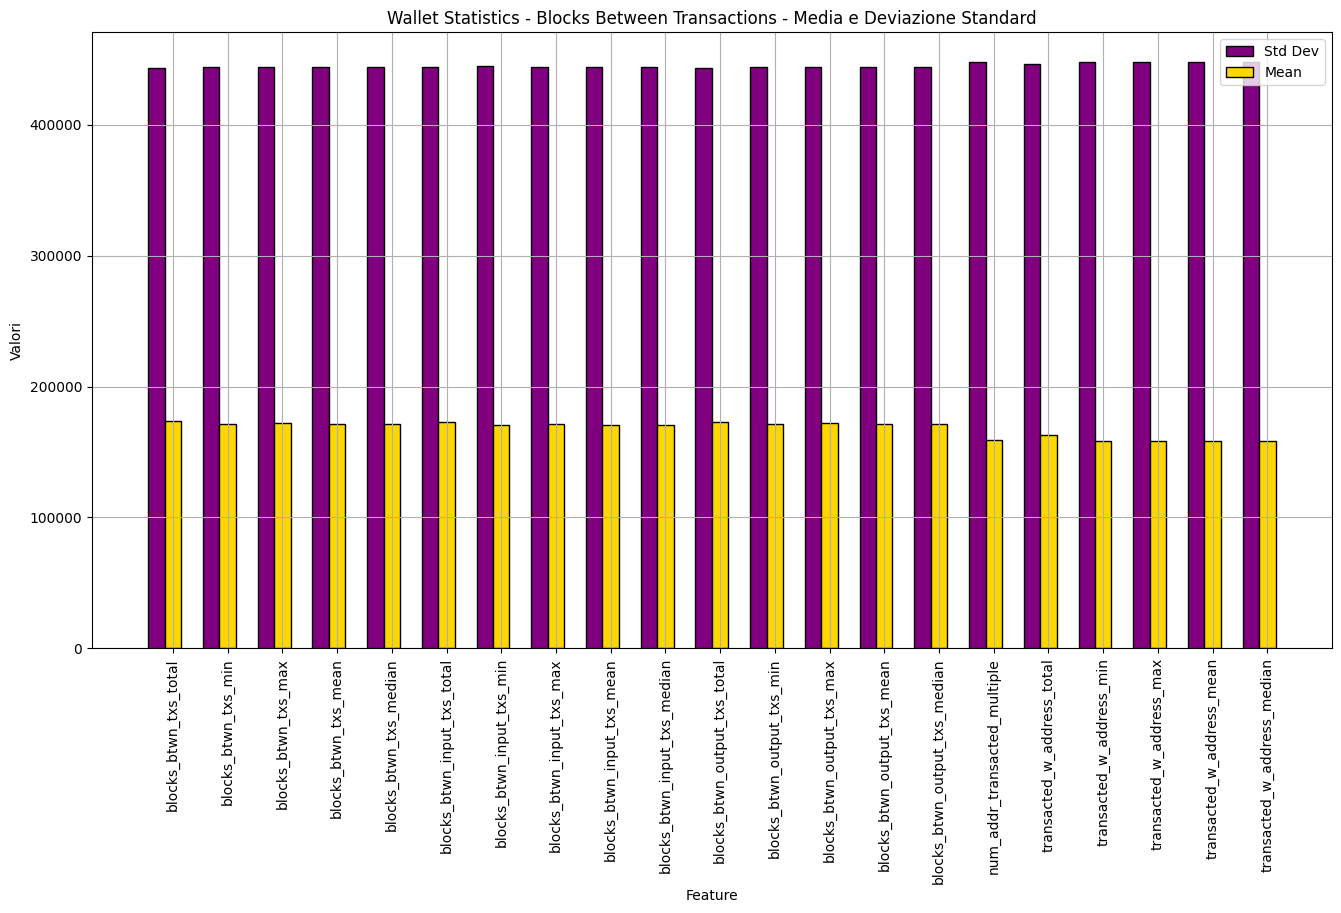

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_feature_statistics(features, statistics, title=''):
    # Estrarre statistiche
    max_values = statistics.loc['max']
    min_values = statistics.loc['min']
    q_25 = statistics.loc['25%']
    q_50 = statistics.loc['50%']
    q_75 = statistics.loc['75%']

    means = statistics.loc['mean']
    std_devs = statistics.loc['std']

    # Grafico per Massimi, Minimi (Istogramma)
    plt.figure(figsize=(16, 8))
    width = 0.3  # Larghezza delle barre
    x = np.arange(len(features))  # Posizioni per le barre

    plt.bar(x - width, max_values, width, label="Max", color="#440154", edgecolor='black')
    plt.bar(x, min_values, width, label="Min", color="#fde725", edgecolor='black')
    plt.xticks(x, features, rotation=90)  # Ruotiamo i nomi delle feature per leggibilità
    plt.xlabel("Feature")
    plt.ylabel("Valori")
    plt.title(f"{title} - Massimi e Minimi")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Grafico per Quartili (Istogramma)
    plt.figure(figsize=(16, 8))
    plt.bar(x - width, q_75, width, label="Q_3", color="#414487", edgecolor='black')
    plt.bar(x, q_50, width, label="Q_2", color="#2A788e", edgecolor='black')
    plt.bar(x + width, q_25, width, label="Q_1", color="#22A884", edgecolor='black')
    plt.xticks(x, features, rotation=90)  # Ruotiamo i nomi delle feature per leggibilità
    plt.xlabel("Feature")
    plt.ylabel("Valori")
    plt.title(f"{title} - Andamento Quartili")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Grafico per Media e Deviazione Standard (Istogramma)
    plt.figure(figsize=(16, 8))
    plt.bar(x - width, std_devs, width, label="Std Dev", color="purple", edgecolor='black')
    plt.bar(x, means, width, label="Mean", color="gold", edgecolor='black')
    plt.xticks(x, features, rotation=90)
    plt.xlabel("Feature")
    plt.ylabel("Valori")
    plt.title(f"{title} - Media e Deviazione Standard")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_statistics(data, features, title=''):
    # Definizione dei gruppi di feature
    feature_groups = {
        "Time-related": [
            'Time step', 'first_block_appeared_in', 'last_block_appeared_in',
            'lifetime_in_blocks', 'num_timesteps_appeared_in',
            'first_sent_block', 'first_received_block'
        ],
        "Transaction-related": [
            'num_txs_as_sender', 'num_txs_as_receiver', 'total_txs'
        ],
        "BTC Transacted": [
            'btc_transacted_total', 'btc_transacted_min', 'btc_transacted_max',
            'btc_transacted_mean', 'btc_transacted_median',
            'btc_sent_total', 'btc_sent_min', 'btc_sent_max',
            'btc_sent_mean', 'btc_sent_median',
            'btc_received_total', 'btc_received_min', 'btc_received_max',
            'btc_received_mean', 'btc_received_median',
            'fees_total', 'fees_min', 'fees_max', 'fees_mean', 'fees_median',
            'fees_as_share_total', 'fees_as_share_min', 'fees_as_share_max',
            'fees_as_share_mean', 'fees_as_share_median'
        ],
        "Blocks Between Transactions": [
            'blocks_btwn_txs_total', 'blocks_btwn_txs_min', 'blocks_btwn_txs_max',
            'blocks_btwn_txs_mean', 'blocks_btwn_txs_median',
            'blocks_btwn_input_txs_total', 'blocks_btwn_input_txs_min', 'blocks_btwn_input_txs_max',
            'blocks_btwn_input_txs_mean', 'blocks_btwn_input_txs_median',
            'blocks_btwn_output_txs_total', 'blocks_btwn_output_txs_min', 'blocks_btwn_output_txs_max',
            'blocks_btwn_output_txs_mean', 'blocks_btwn_output_txs_median',
            'num_addr_transacted_multiple', 'transacted_w_address_total', 'transacted_w_address_min',
            'transacted_w_address_max', 'transacted_w_address_mean', 'transacted_w_address_median'
        ]
    }

    # Creiamo un dizionario per contenere le statistiche di ogni gruppo
    statistics_by_group = {}

    for group_name, group_features in feature_groups.items():
        # Selezioniamo solo le feature presenti nei dati
        selected_features = [f for f in group_features if f in features]

        if selected_features:
            # Creiamo un dataframe con le feature selezionate
            statistics_by_group[group_name] = data[selected_features].describe()

    # Creazione dei grafici per ogni categoria
    for group_name, stats_df in statistics_by_group.items():
        plot_feature_statistics(stats_df.columns, stats_df, title=f"{title} - {group_name}")


# Eseguiamo la funzione
statistics = wallets_features_classes_combined.describe()  # Assicurati che questo contenga i dati corretti
plot_statistics(statistics, features, title="Wallet Statistics")


In [ ]:
    feature_groups = {
        "Time-related": [
            'Time step', 'first_block_appeared_in', 'last_block_appeared_in',
            'lifetime_in_blocks', 'num_timesteps_appeared_in',
            'first_sent_block', 'first_received_block'
        ],
        "Transaction-related": [
            'num_txs_as_sender', 'num_txs_as_receiver', 'total_txs'
        ],
        "BTC Transacted": [
            'btc_transacted_total', 'btc_transacted_min', 'btc_transacted_max',
            'btc_transacted_mean', 'btc_transacted_median',
            'btc_sent_total', 'btc_sent_min', 'btc_sent_max',
            'btc_sent_mean', 'btc_sent_median',
            'btc_received_total', 'btc_received_min', 'btc_received_max',
            'btc_received_mean', 'btc_received_median',
            'fees_total', 'fees_min', 'fees_max', 'fees_mean', 'fees_median',
            'fees_as_share_total', 'fees_as_share_min', 'fees_as_share_max',
            'fees_as_share_mean', 'fees_as_share_median'
        ],
        "Blocks Between Transactions": [
            'blocks_btwn_txs_total', 'blocks_btwn_txs_min', 'blocks_btwn_txs_max',
            'blocks_btwn_txs_mean', 'blocks_btwn_txs_median',
            'blocks_btwn_input_txs_total', 'blocks_btwn_input_txs_min', 'blocks_btwn_input_txs_max',
            'blocks_btwn_input_txs_mean', 'blocks_btwn_input_txs_median',
            'blocks_btwn_output_txs_total', 'blocks_btwn_output_txs_min', 'blocks_btwn_output_txs_max',
            'blocks_btwn_output_txs_mean', 'blocks_btwn_output_txs_median',
            'num_addr_transacted_multiple', 'transacted_w_address_total', 'transacted_w_address_min',
            'transacted_w_address_max', 'transacted_w_address_mean', 'transacted_w_address_median'
        ]
    }

In [ ]:
for group_name, features in feature_groups.items():
    # Seleziona solo le feature presenti in statistc
    valid_features = [f for f in features if f in statistc.index]

    if valid_features:  # Controlla che ci siano feature valide
        min_range = statistc.loc[valid_features, "min"].min()
        max_range = statistc.loc[valid_features, "min"].max()
        print(f'Min {group_name}: {min_range} - {max_range}')

        min_range = statistc.loc[valid_features, "max"].min()
        max_range = statistc.loc[valid_features, "max"].max()
        print(f'Max {group_name}: {min_range} - {max_range}')

        print()


Min Time-related: 0.0 - 391200.0
Max Time-related: 47.0 - 487975.0

Min Transaction-related: 0.0 - 1.0
Max Transaction-related: 1453.0 - 1471.0

Min BTC Transacted: 0.0 - 0.0
Max BTC Transacted: 0.2652322129 - 32412.3

Min Blocks Between Transactions: 0.0 - 1.0
Max Blocks Between Transactions: 41.0 - 96775.0



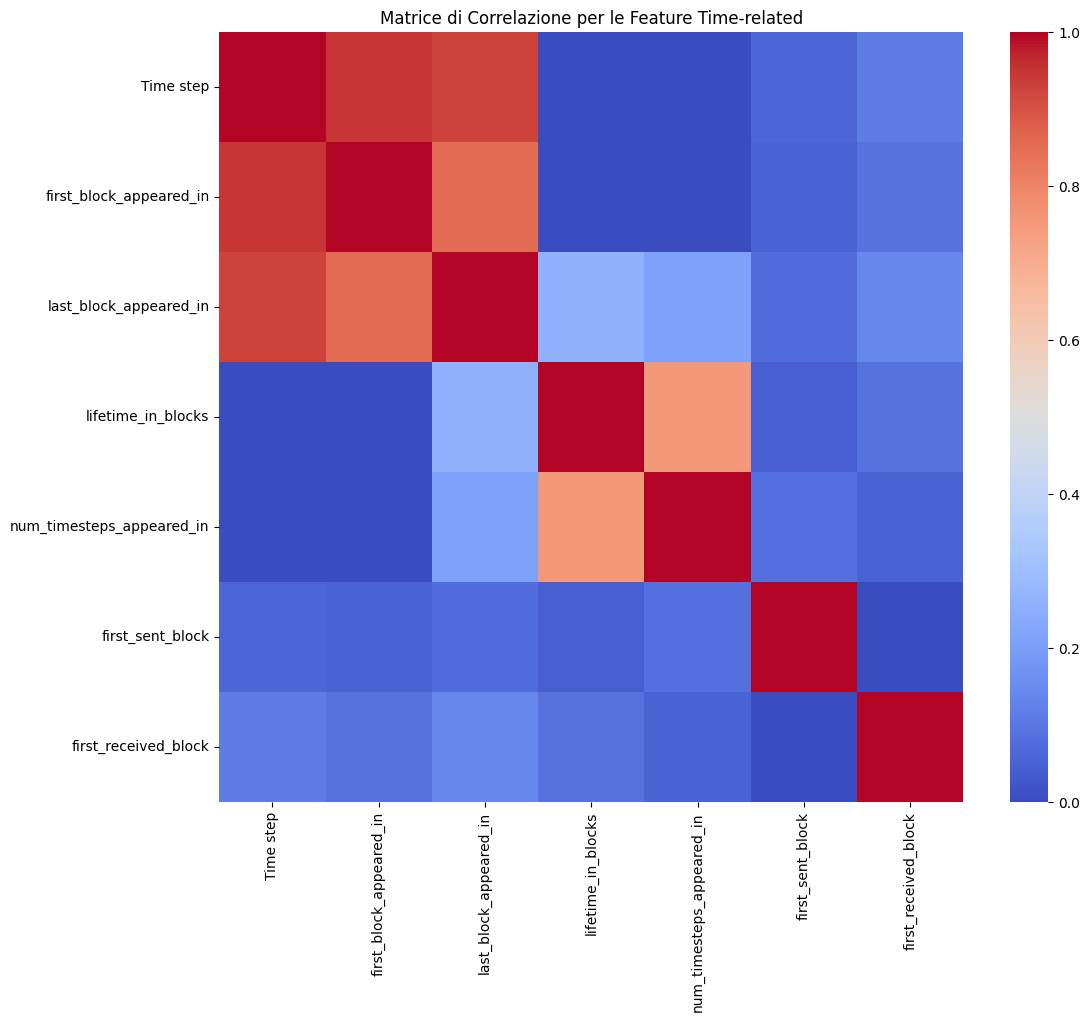

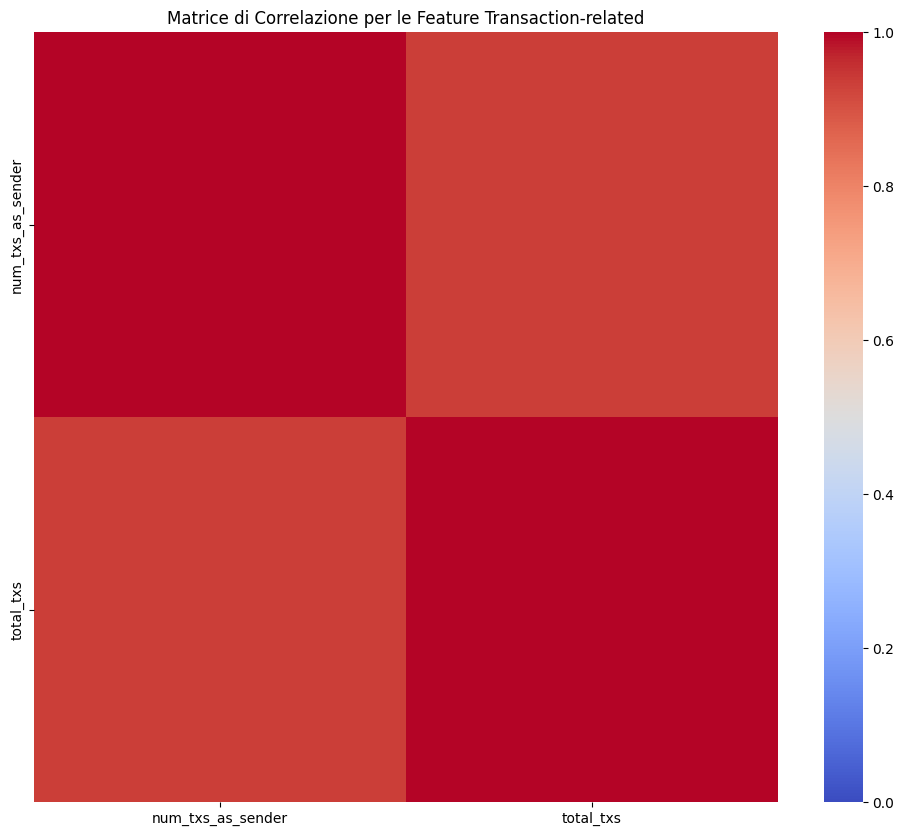

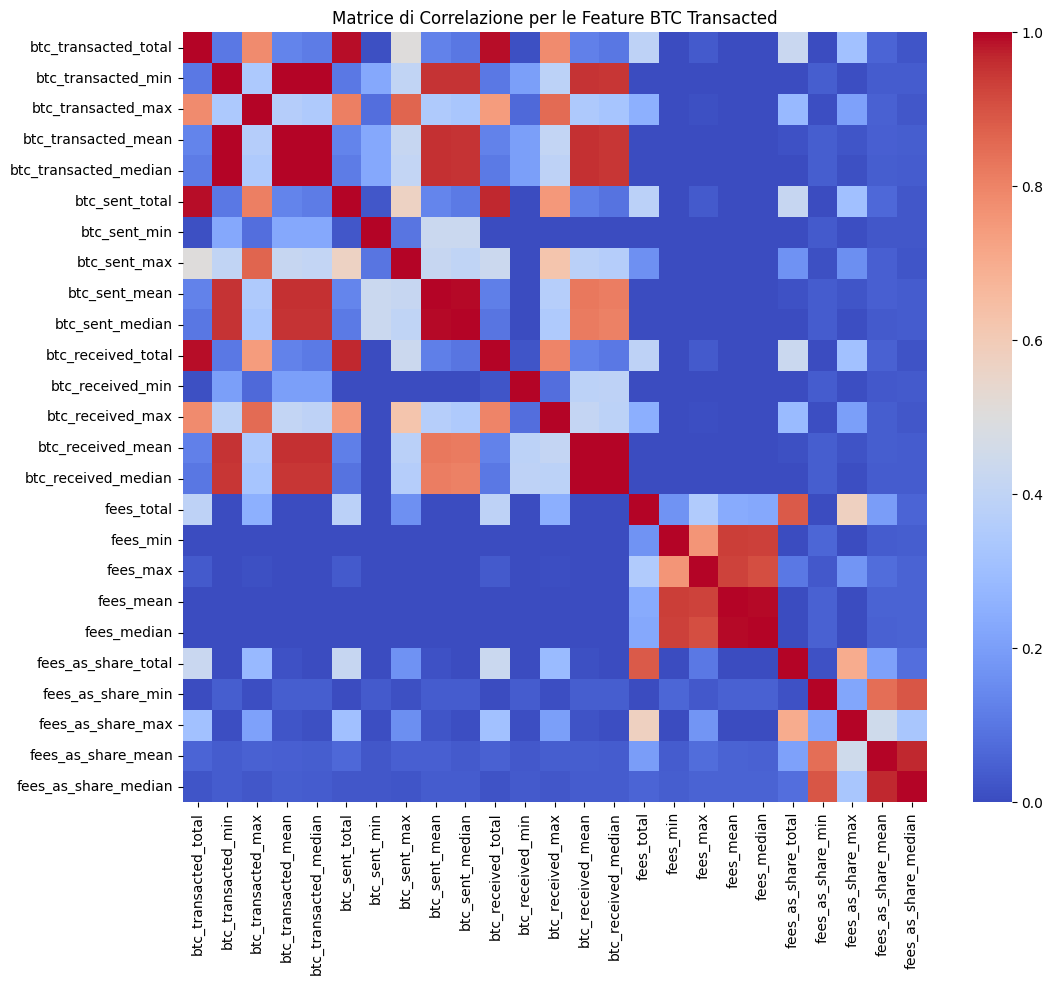

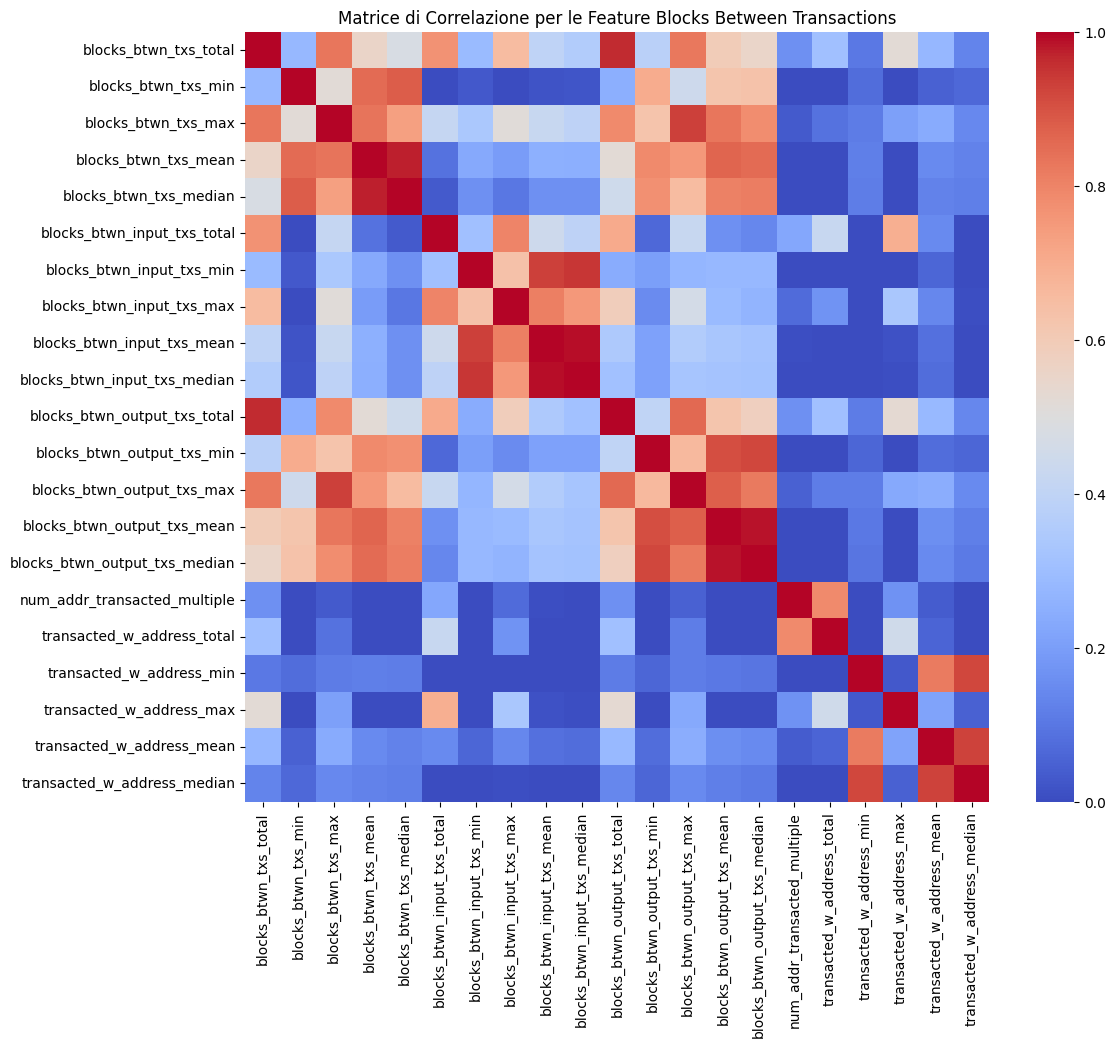

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def corr_matrix(df, feature_group, title):
    """
    Genera una matrice di correlazione per il gruppo di feature selezionato.
    """
    # Seleziona solo le colonne nel gruppo di feature
    selected_columns = feature_groups[feature_group]

    # Assicurati che le colonne esistano nel DataFrame
    selected_columns = [col for col in selected_columns if col in df.columns]

    # Filtra il dataframe per includere solo le colonne selezionate
    df_filtered = df[selected_columns]

    # Calcola la matrice di correlazione
    corr_matrix = df_filtered.corr()

    # Crea una figura più grande
    plt.figure(figsize=(12, 10))  # Imposta le dimensioni (larghezza, altezza)

    # Crea la heatmap con Seaborn
    sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", vmin=0)

    plt.title(title)
    plt.show()

# Esempio di chiamate per diversi gruppi di feature
corr_matrix(wallets_features_classes_combined.copy(), "Time-related", title='Matrice di Correlazione per le Feature Time-related')
corr_matrix(wallets_features_classes_combined.copy(), "Transaction-related", title='Matrice di Correlazione per le Feature Transaction-related')
corr_matrix(wallets_features_classes_combined.copy(), "BTC Transacted", title='Matrice di Correlazione per le Feature BTC Transacted')
corr_matrix(wallets_features_classes_combined.copy(), "Blocks Between Transactions", title='Matrice di Correlazione per le Feature Blocks Between Transactions')


-0.019538495084180325 0.12610295418215164


<ipython-input-92-6367365093b4>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_class.values, y=feature_labels, palette=colors)
<ipython-input-92-6367365093b4>:30: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(x=correlation_with_class.values, y=feature_labels, palette=colors)


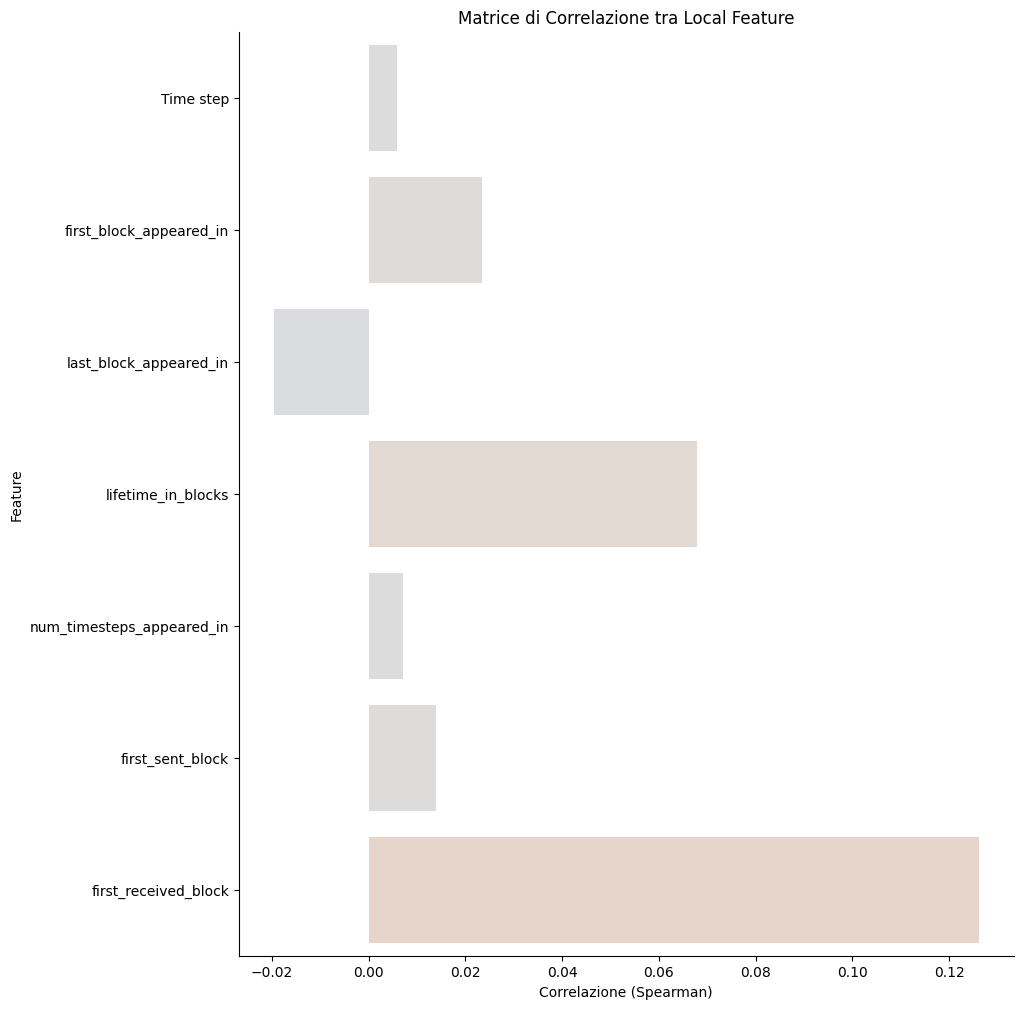

0.019929058092257097 0.1315058197179747


<ipython-input-92-6367365093b4>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_class.values, y=feature_labels, palette=colors)
<ipython-input-92-6367365093b4>:30: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(x=correlation_with_class.values, y=feature_labels, palette=colors)


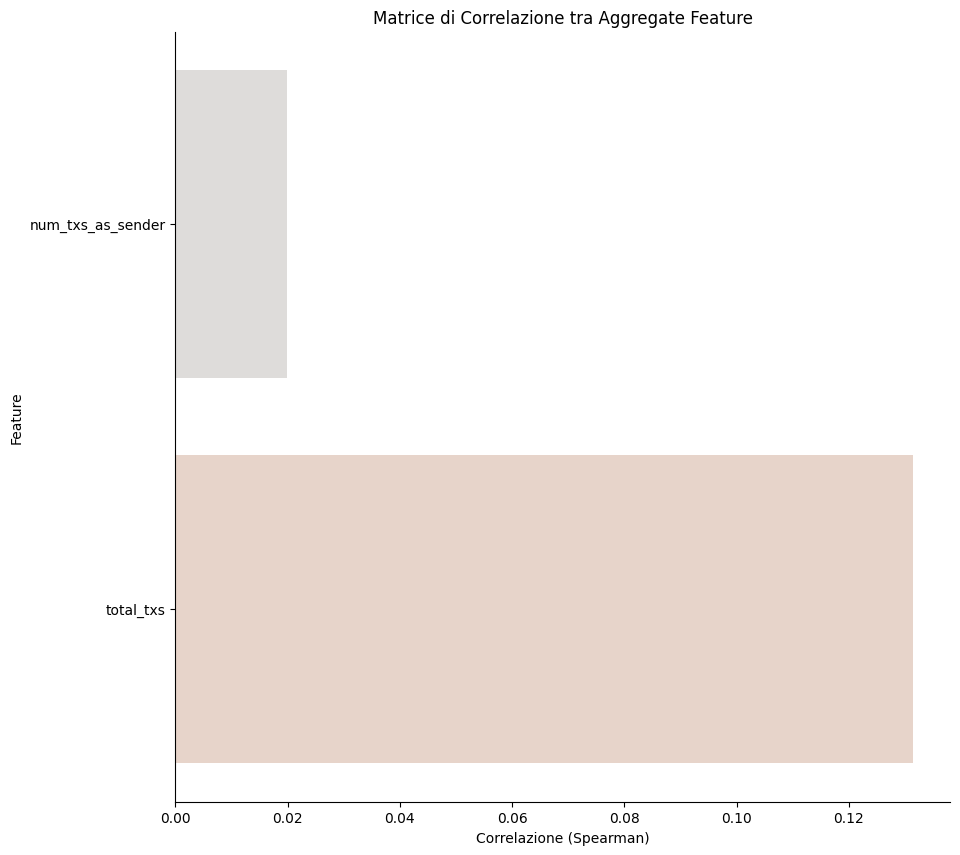

-0.13919502253952376 0.1754577724779018


<ipython-input-92-6367365093b4>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_class.values, y=feature_labels, palette=colors)
<ipython-input-92-6367365093b4>:30: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(x=correlation_with_class.values, y=feature_labels, palette=colors)


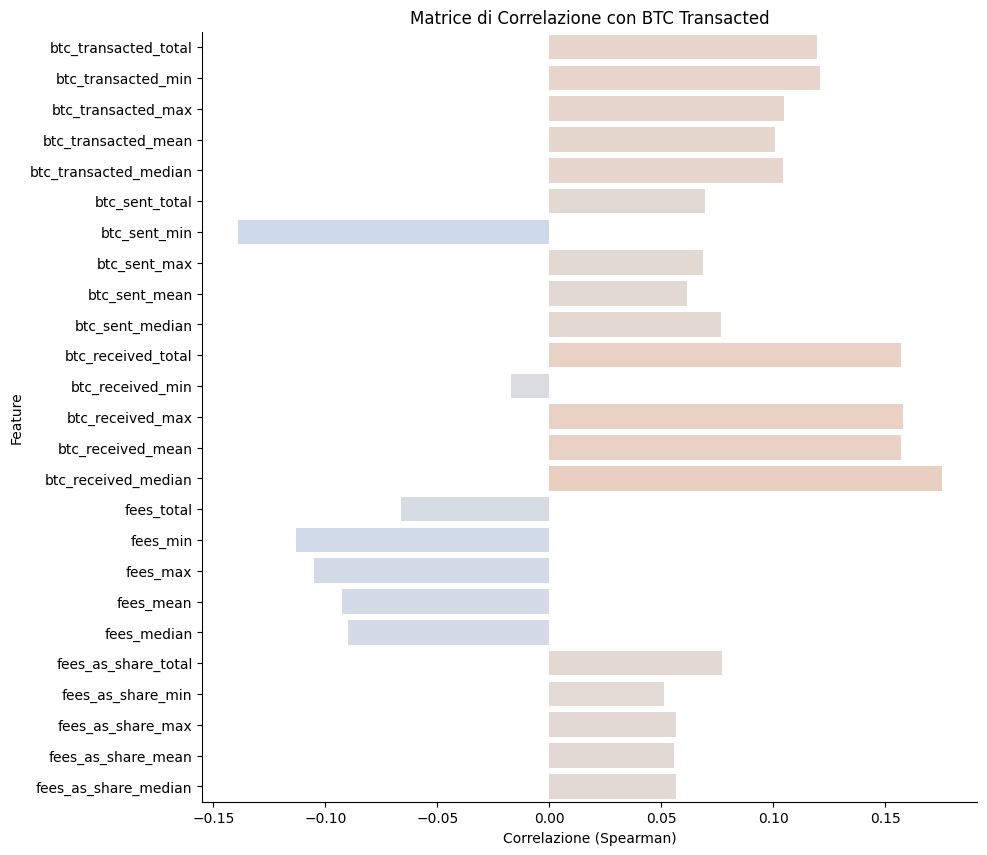

-0.1068071072535128 0.0968084160264568


<ipython-input-92-6367365093b4>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_class.values, y=feature_labels, palette=colors)
<ipython-input-92-6367365093b4>:30: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(x=correlation_with_class.values, y=feature_labels, palette=colors)


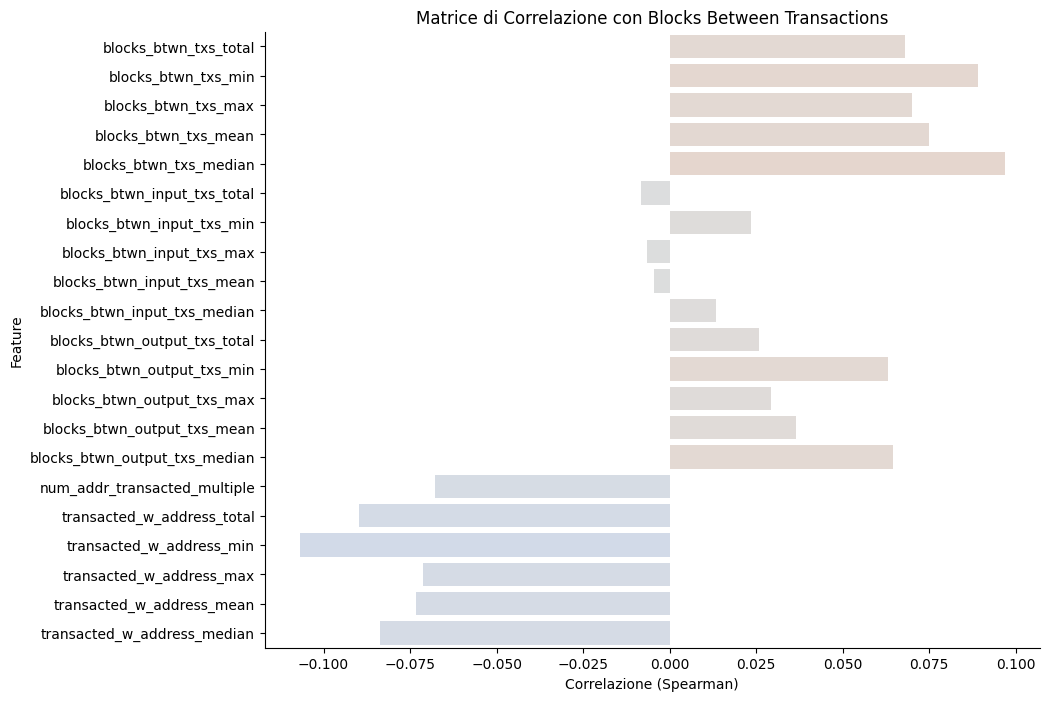

In [ ]:
def corr_matrix_class(df, feature_group, title, h=10):
    """
    Genera una matrice di correlazione di Spearman per il gruppo di feature selezionato.
    """
    # Selezionare solo le colonne nel gruppo di feature
    selected_columns = feature_groups[feature_group] + ['class']

    # Verifica che le colonne selezionate esistano nel DataFrame
    selected_columns = [col for col in selected_columns if col in df.columns]

    # Calcolo della correlazione di Spearman
    correlation_matrix = df[selected_columns].corr(method="spearman")

    # Selezionare solo le correlazioni con la colonna "class"
    correlation_with_class = correlation_matrix["class"].drop("class")

    print(f'{correlation_with_class.min()} {correlation_with_class.max()}')

    # Normalizzazione nel range [-1, 1] per la palette "coolwarm"
    norm_corr = (correlation_with_class + 1) / 2  # Converte da [-1,1] → [0,1]

    # Generazione della palette in base ai valori normalizzati
    cmap = sns.color_palette("coolwarm", as_cmap=True)  # Mappa colori da -1 a 1
    colors = cmap(norm_corr)  # Applica la mappa colori ai valori normalizzati

    # 🎨 Grafico della correlazione con "class"
    plt.figure(figsize=(10, h))
    # Rimuovi i prefissi dai nomi delle feature
    feature_labels = [x.replace('Local_feature_', '').replace('Aggregate_feature_', '') for x in correlation_with_class.index]
    sns.barplot(x=correlation_with_class.values, y=feature_labels, palette=colors)

    plt.xlabel("Correlazione (Spearman)")
    plt.ylabel("Feature")
    plt.title(title)
    # 📌 Rimuovi i bordi superiore e destro
    sns.despine(top=True, right=True)  # Aggiungi questa linea per rimuovere bordi

    plt.show()

# Esempio di chiamate per diversi gruppi di feature
corr_matrix_class(wallets_features_classes_combined.copy(), "Time-related", title='Matrice di Correlazione tra Local Feature', h=12)
corr_matrix_class(wallets_features_classes_combined.copy(), "Transaction-related", title='Matrice di Correlazione tra Aggregate Feature')
corr_matrix_class(wallets_features_classes_combined.copy(), "BTC Transacted", title='Matrice di Correlazione con BTC Transacted', h=10)
corr_matrix_class(wallets_features_classes_combined.copy(), "Blocks Between Transactions", title='Matrice di Correlazione con Blocks Between Transactions', h=8)

<ipython-input-6-ab78def80546>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df_classes, x="class", palette=colors)


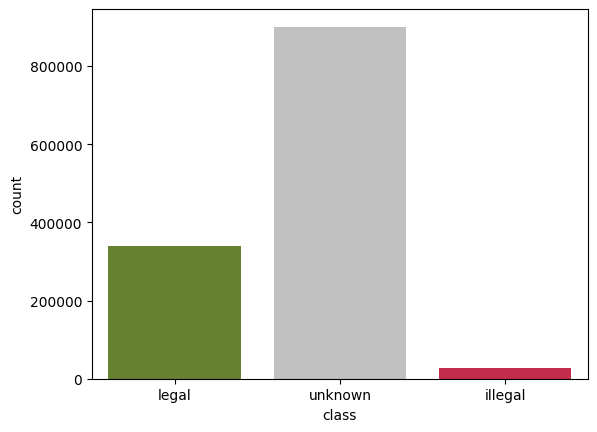

In [ ]:
# Definisci i colori per ogni classe
colors = ["olivedrab","silver", "crimson" ]
class_map = {1: "illegal", 2: "legal", 3: "unknown"}

df_classes = wallets_features_classes_combined.copy()
df_classes['class'] = df_classes['class'].map(class_map) # Use map instead of apply

# Crea il countplot con i colori specificati
sns.countplot(df_classes, x="class", palette=colors)

# Mostra il grafico
plt.show()

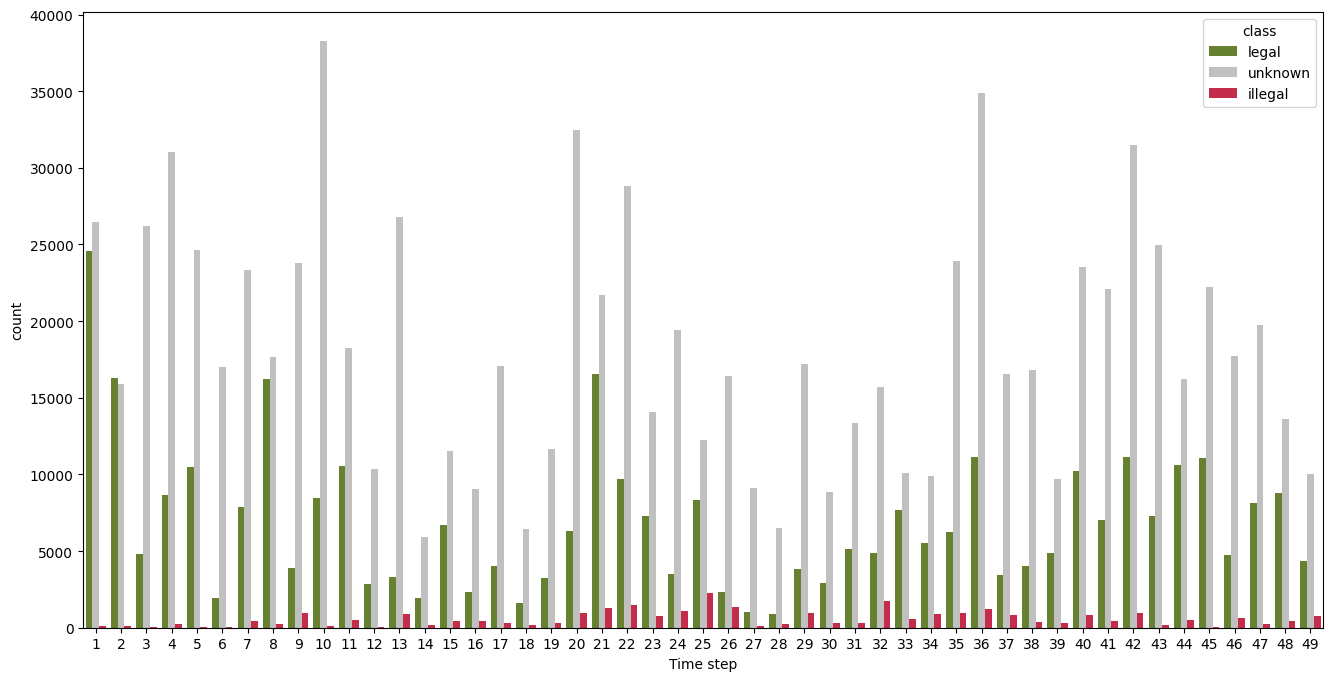

In [ ]:
# Crea una figura più grande
plt.figure(figsize=(16, 8))  # Imposta le dimensioni in pollici (larghezza, altezza)

# Crea il countplot con i colori specificati e la figura più grande
sns.countplot(df_classes, x="Time step", hue="class", palette=colors)

# Mostra il grafico
plt.show()

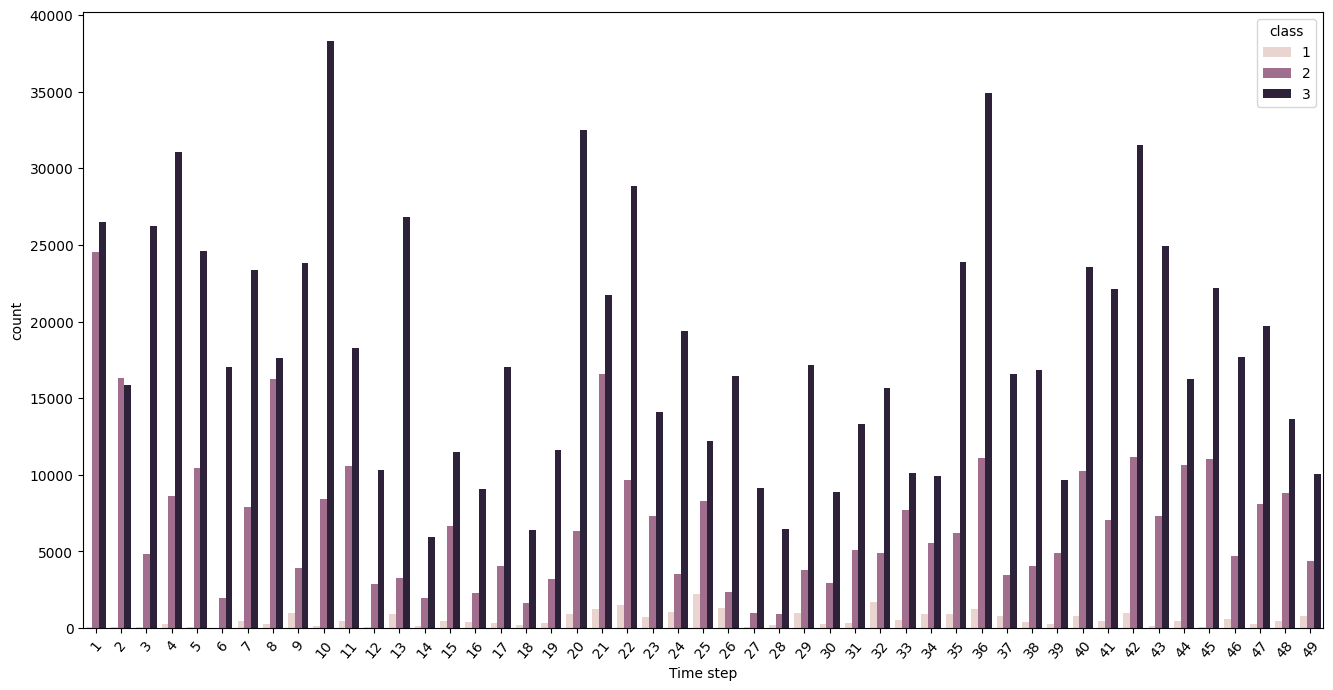

In [ ]:
plt.figure(figsize=(16, 8))
sns.countplot(wallets_features_classes_combined, x="Time step", hue="class")

# Ruotare le etichette
plt.xticks(rotation=50)

# Mostra il grafico
plt.show()